# Calibration: MST midE ($E_c \in [4-14]$ keV)
### Patrick VanMeter
### January 2019

In [1]:
import os
import time
import cPickle as pickle
import gc
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
import mesxr.calibration.trimscan as calib
import mesxr.calibration.plots as plot
import mesxr.calibration.utilities as util

%matplotlib inline

First, let's do the actual calibration using my new calibration library. Then, the results will be examined and compared to the old method.

In [2]:
calib_base = '/home/pdvanmeter/data/meSXR/MST/trimscan_data/2017-06-20_4_to_12_keV_quickscan'
elements = ['Br', 'Cr', 'Cu', 'Fe', 'Ge']
trimscan_paths = [os.path.join(calib_base, 'calib_line={0:}_vrfp=-0.100_vadj=1.154_vtrm=1.150_vcmp=0.800_trim=scan'.format(elem)) for elem in elements]
settings_path = trimscan_paths[0]
bad_pix = [(12, 71), (122, 60), (198, 117), (274, 130), (376, 94)]

load_calibration = True
save_path = '/home/pdvanmeter/data/meSXR/MST/calibration/pickles'
calibration_name = 'MST_midE.pkl'

In [3]:
start_t = time.time()

if not load_calibration:
    p3_det = calib.Pilatus3_100k(elements, trimscan_paths, settings_path, calib_name='MST_midE')
    p3_det.calibrate(num_cores=16, bad_pix=bad_pix)
    
    # Save the resulting calibration for future use
    file = open(os.path.join(save_path, calibration_name), 'wb')
    gc.disable()
    pickle.dump(p3_det, file)
    gc.enable()
    file.close()
else:
    # Load the full results
    file = open(os.path.join(save_path, calibration_name), 'rb')
    gc.disable()
    p3_det = pickle.load(file)
    gc.enable()
    file.close()

end_t = time.time()
print('{0:.2f} min. elapsed.'.format((end_t-start_t)/60.))

1.67 min. elapsed.


## 1 - Basic Analysis

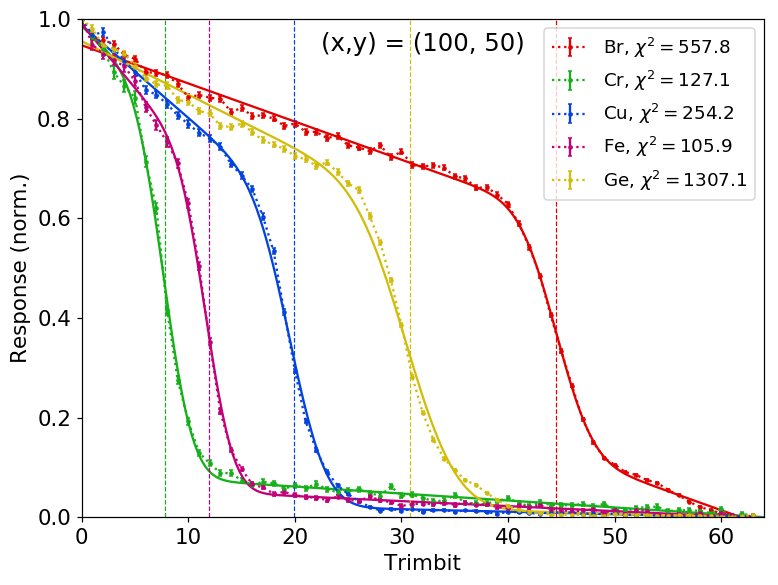

In [4]:
fig = plot.s_curves_plot(p3_det, 100, 50)

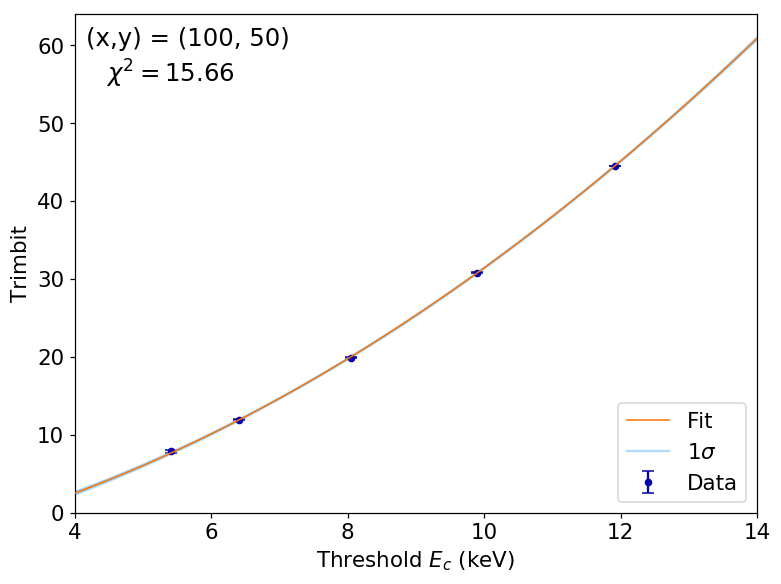

In [5]:
fig = plot.trimscan_curve(p3_det, 100, 50, xlim=[4,14])

Let's look at the distribution of $\chi^2$ values for each individual element.

/home/pdvanmeter/lib/python/mesxr/calibration/plots.py:149: RuntimeWarning: invalid value encountered in greater
  rem_indices = np.where(chi2_set > cutoff)[0]
/home/pdvanmeter/miniconda2/envs/plasma/lib/python2.7/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/pdvanmeter/miniconda2/envs/plasma/lib/python2.7/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


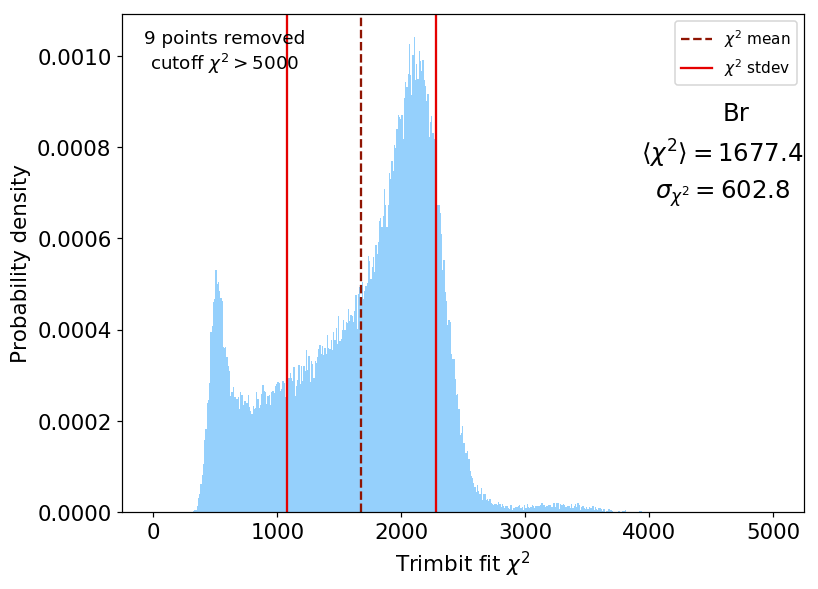

In [6]:
fig = plot.trimscan_chi2_plot(p3_det, 'Br', range(16), chi_range=(0,5000), cutoff=5000, plot_stdev=True)

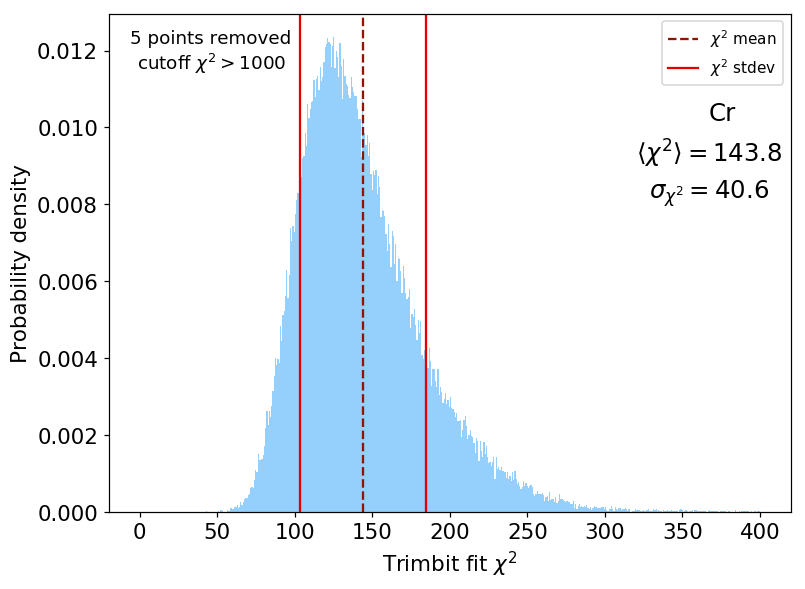

In [7]:
fig = plot.trimscan_chi2_plot(p3_det, 'Cr', range(16), chi_range=(0,400), plot_stdev=True)

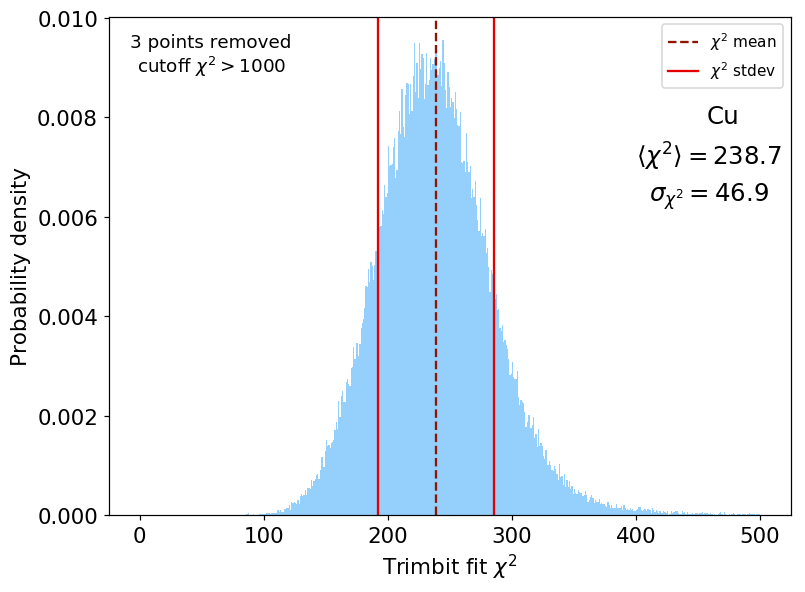

In [8]:
fig = plot.trimscan_chi2_plot(p3_det, 'Cu', range(16), chi_range=(0,500), plot_stdev=True)

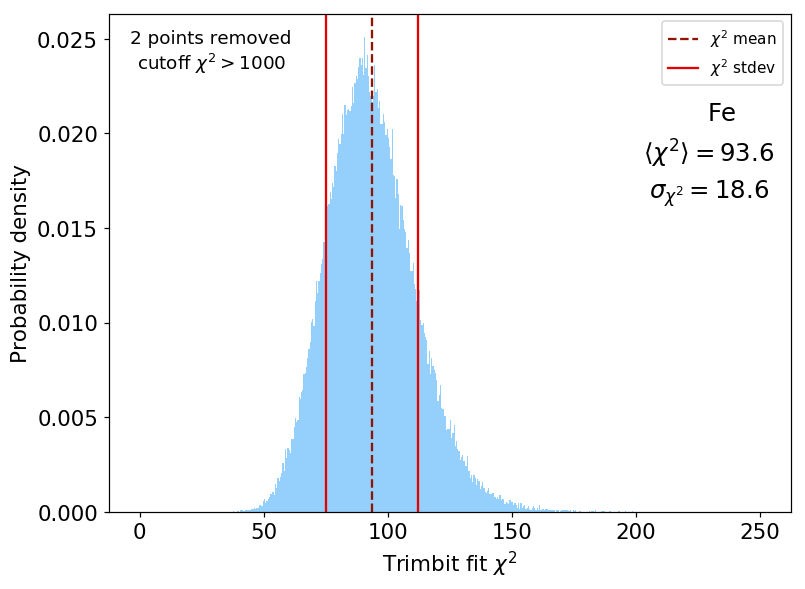

In [9]:
fig = plot.trimscan_chi2_plot(p3_det, 'Fe', range(16), chi_range=(0,250), plot_stdev=True)

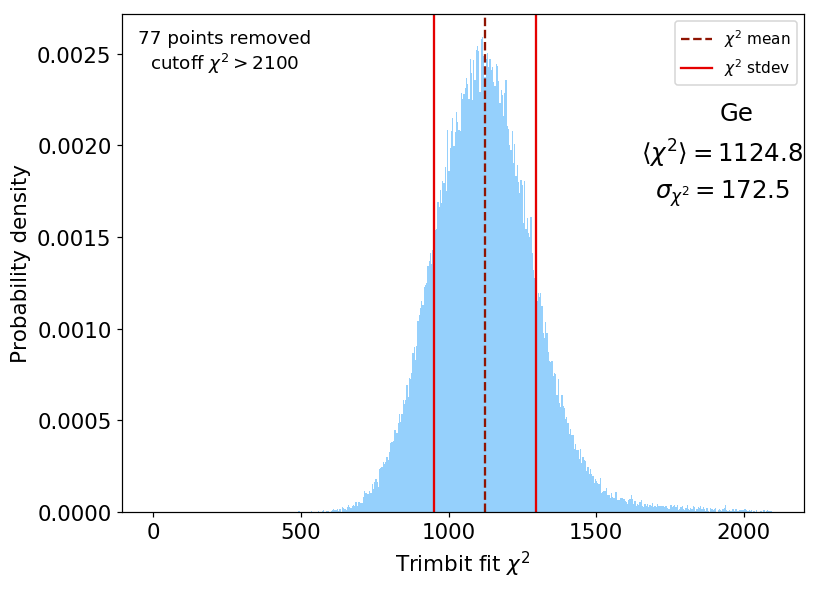

In [10]:
fig = plot.trimscan_chi2_plot(p3_det, 'Ge', range(16), chi_range=(0,2100), cutoff=2100, plot_stdev=True)

We also want to look at the distribution of $\chi^2$ for the energy fit.

/home/pdvanmeter/lib/python/mesxr/calibration/plots.py:206: RuntimeWarning: invalid value encountered in greater
  rem_indices = np.where(chi2_set > cutoff)[0]


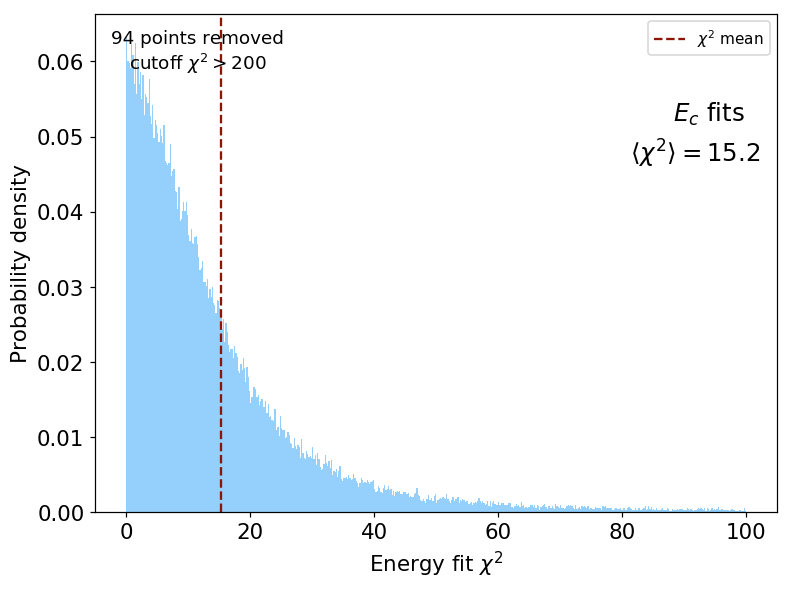

In [11]:
fig = plot.energy_chi2_plot(p3_det, range(16), chi_range=(0, 100), cutoff=200, plot_stdev=False)

## 2 - Corner Plots

Next, we want to look at corner plots for the distributions of the parameters in the fit. As a reminder, the trimscan data is fit to the following equation:

$N(\hat{t}) = \frac{1}{2} \bigg[erf(-\frac{\hat{t} - a_0}{\sqrt{2} a_1}) + 1\bigg] \cdot \big(a_2 + a_3 (\hat{t} - a_0)\big) + a_4 + a_5 (\hat{t} - a_0)$

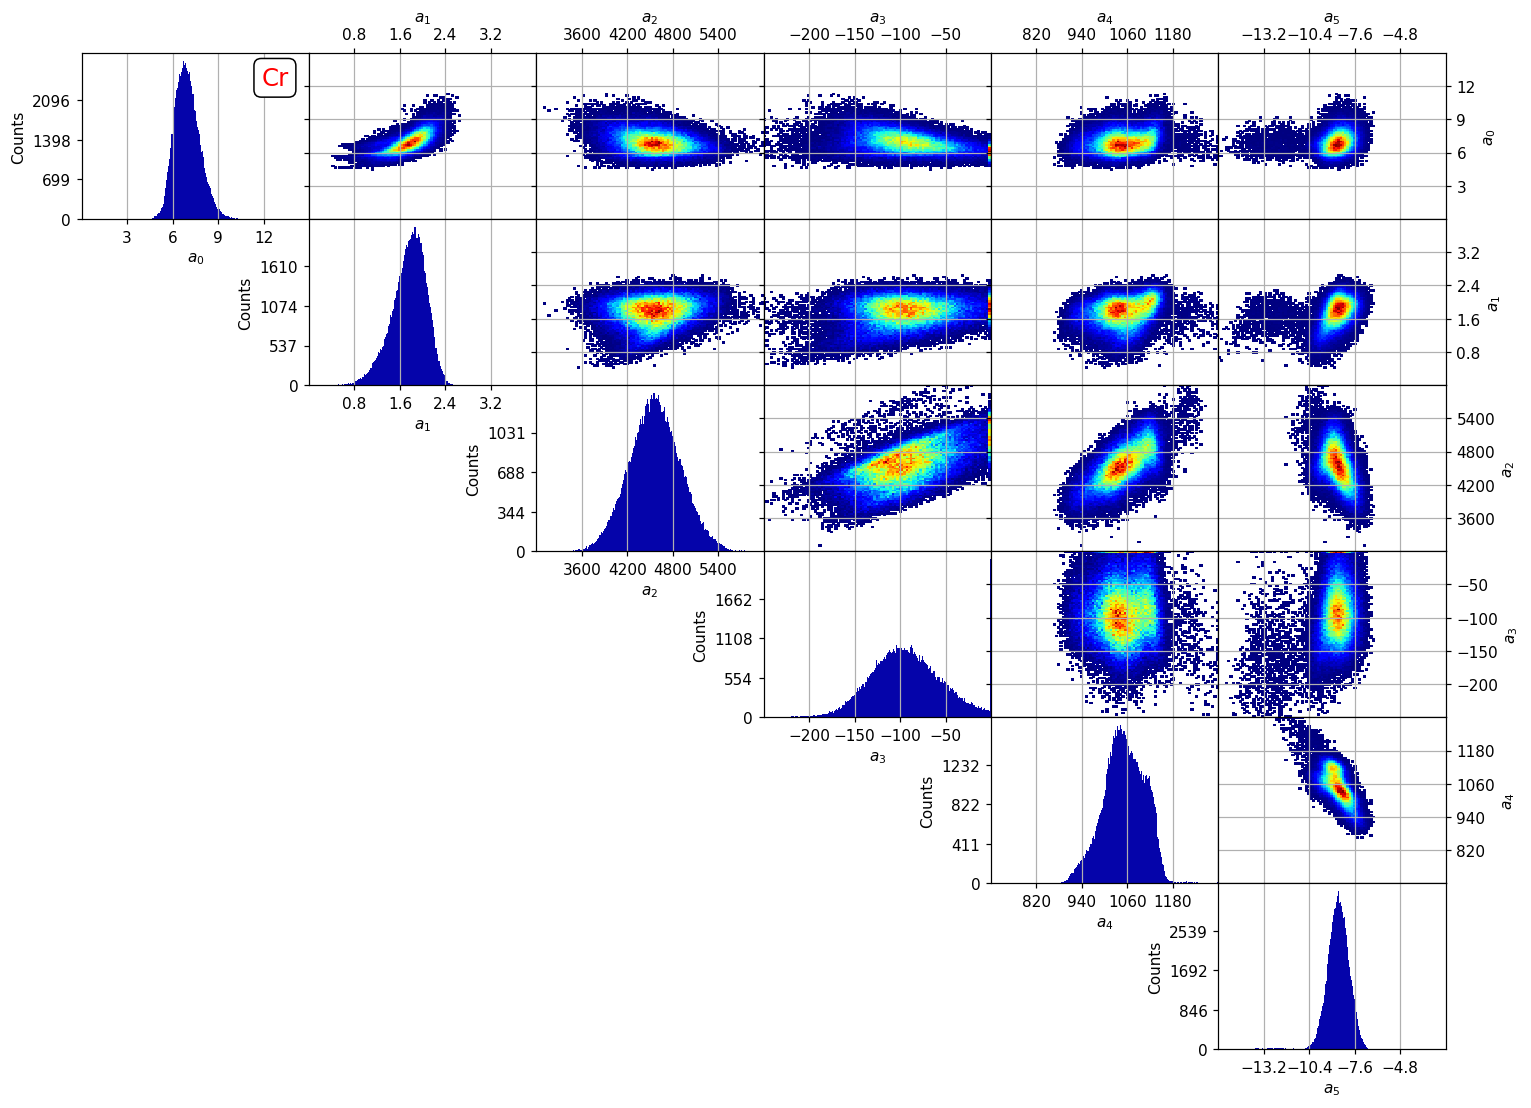

In [12]:
#           a0         a1           a2            a3           a4           a5
ranges = [[0, 15], [0.0, 4.0], [3000, 6000], [-250, 0], [700, 1300], [-16, -2]]
element = 'Cr'

fig = plot.trimscan_corner_plot(p3_det, element, ranges)

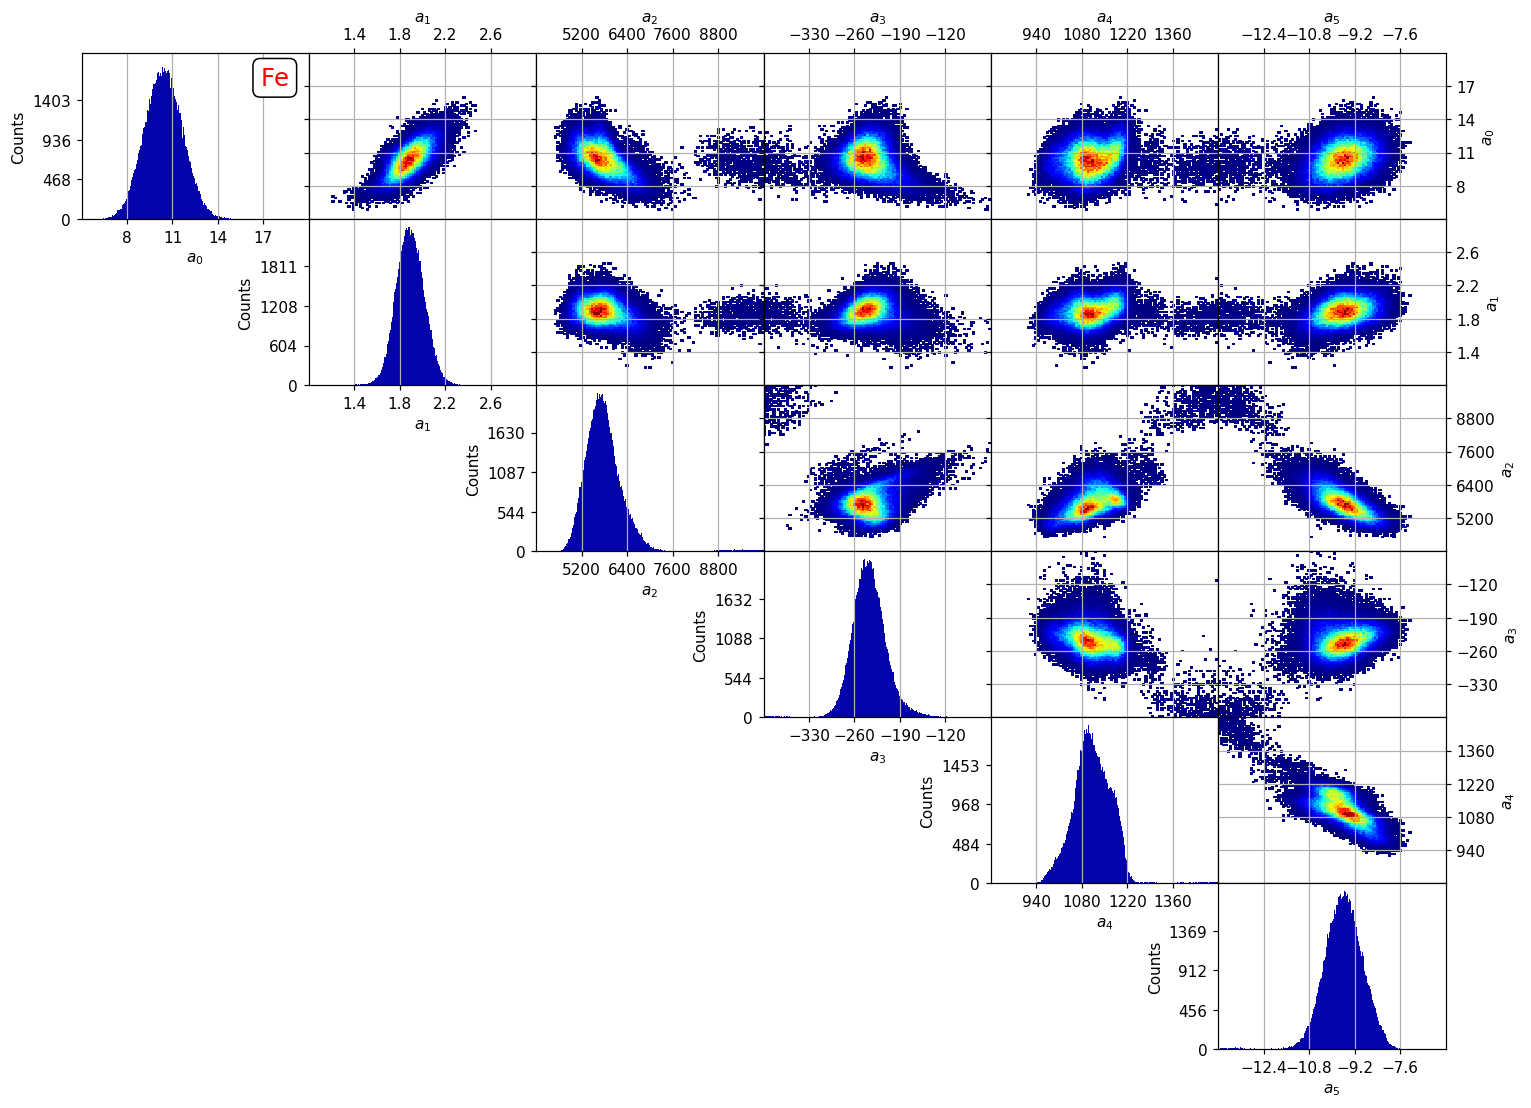

In [13]:
#           a0         a1           a2            a3           a4           a5
ranges = [[5, 20], [1.0, 3.0], [4000, 10000], [-400, -50], [800, 1500], [-14, -6]]
element = 'Fe'

fig = plot.trimscan_corner_plot(p3_det, element, ranges)

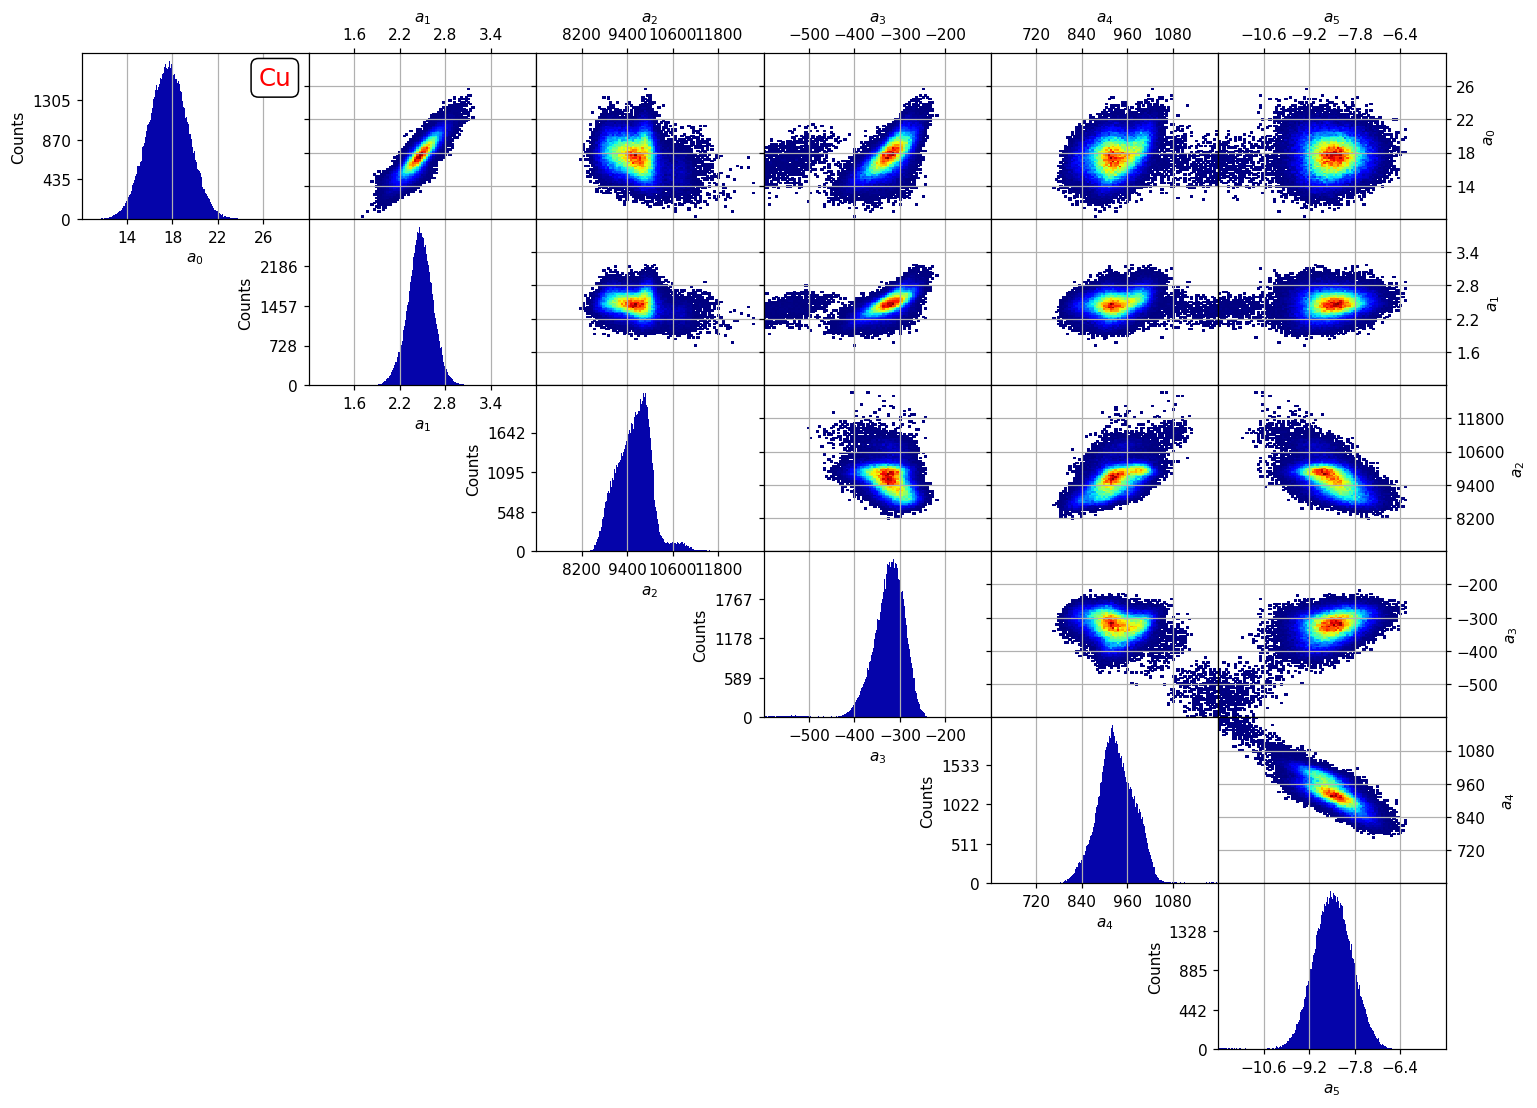

In [14]:
#           a0         a1           a2            a3           a4           a5
ranges = [[10, 30], [1.0, 4.0], [7000, 13000], [-600, -100], [600, 1200], [-12, -5]]
element = 'Cu'

fig = plot.trimscan_corner_plot(p3_det, element, ranges)

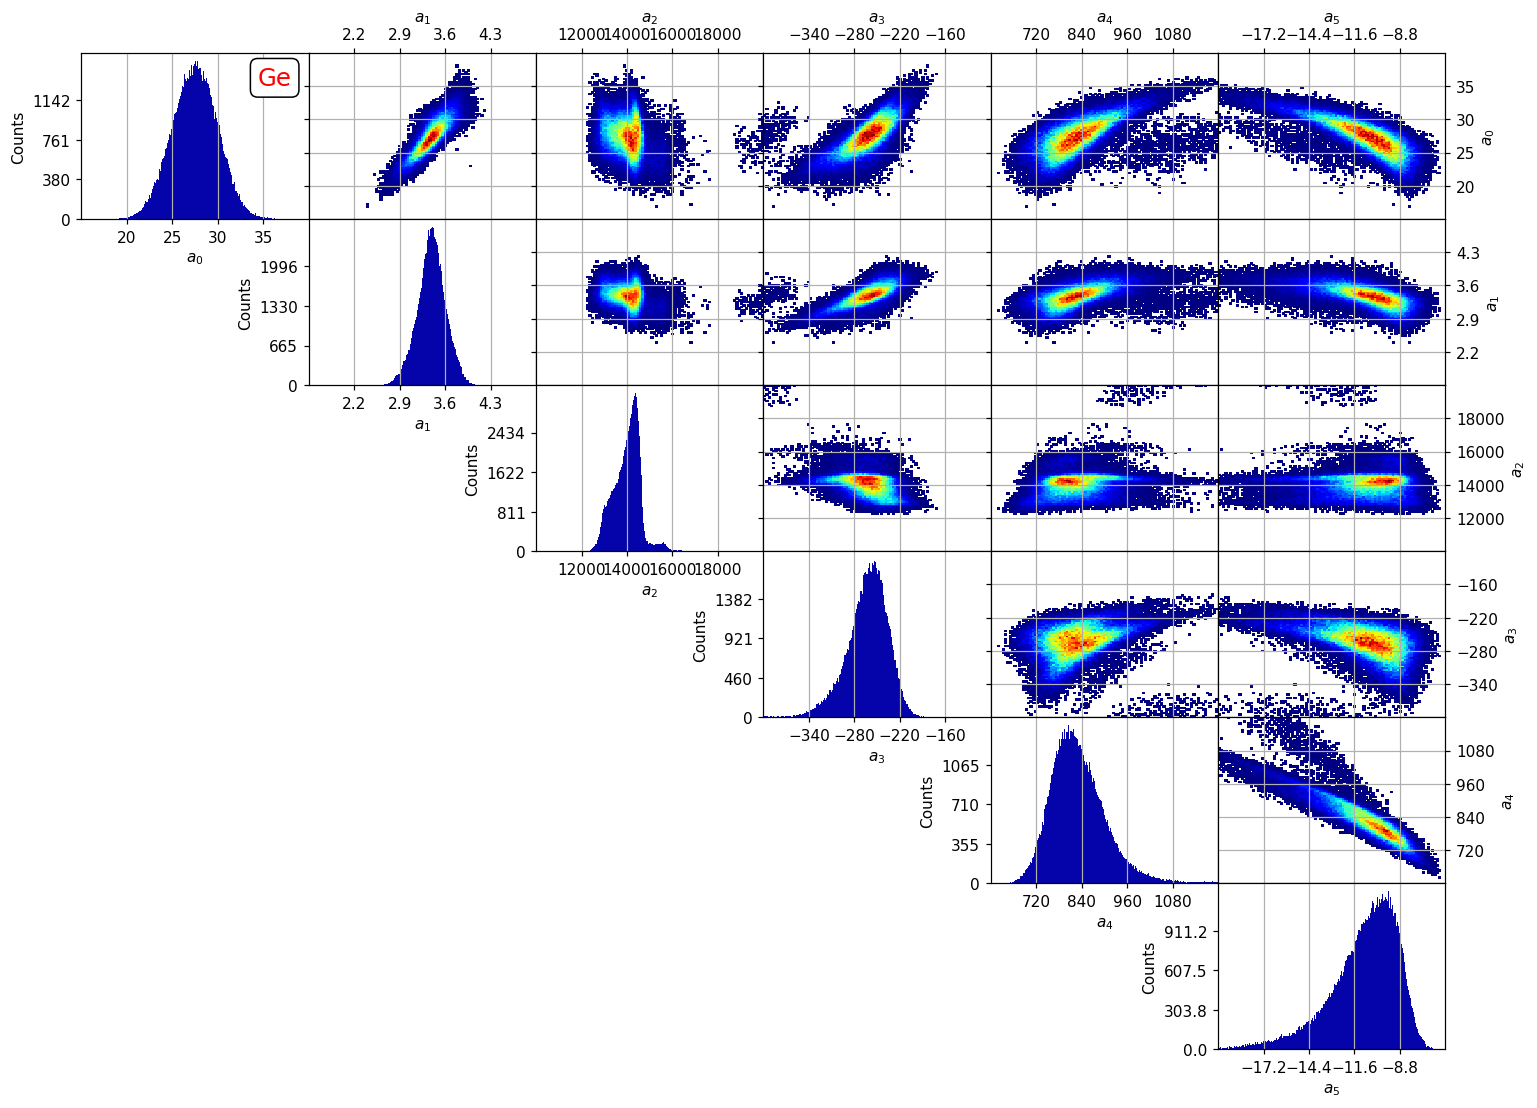

In [15]:
#            a0         a1           a2             a3           a4           a5
ranges = [[15, 40], [1.5, 5.0], [10000, 20000], [-400, -100], [600, 1200], [-20, -6]]
element = 'Ge'

fig = plot.trimscan_corner_plot(p3_det, element, ranges)

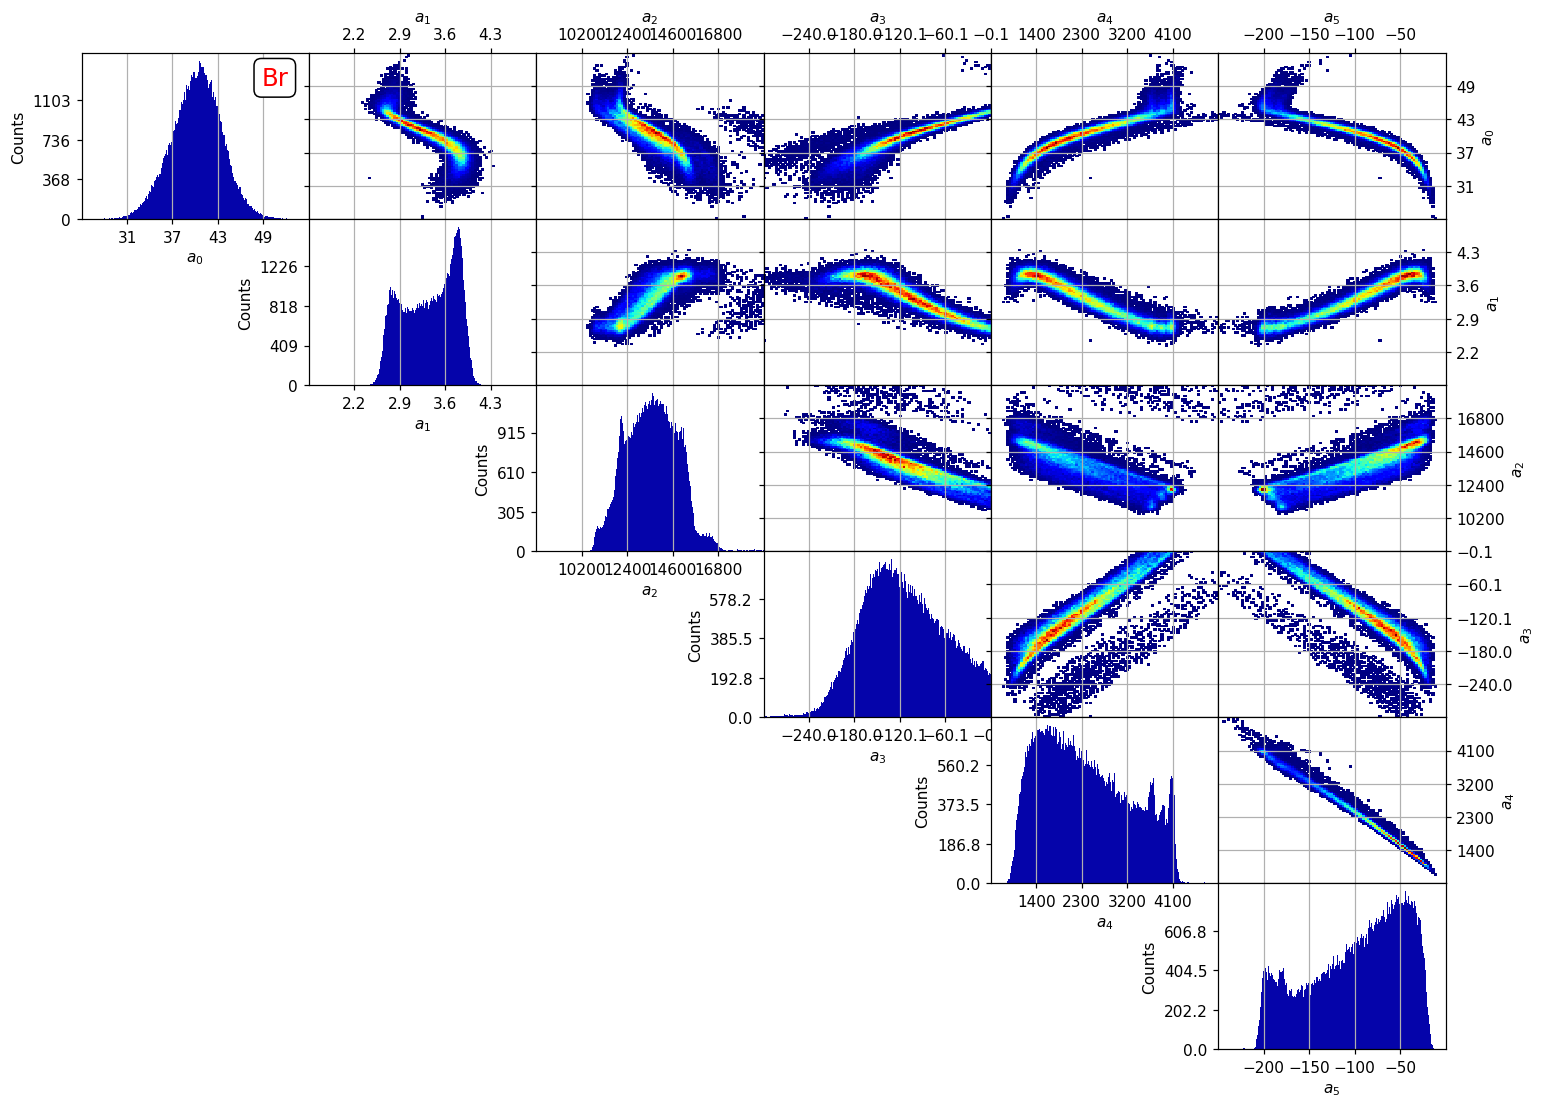

In [16]:
#            a0         a1           a2             a3           a4           a5
ranges = [[25, 55], [1.5, 5.0], [8000, 19000], [-300, -0.1], [500, 5000], [-250, 0]]
element = 'Br'

fig = plot.trimscan_corner_plot(p3_det, element, ranges)

Now, let's look at the corner plot for the quadratic energy fit, given by:

$\hat{t}(E_c) = c_0 E_c^2 + c_1 E_c + c_2$

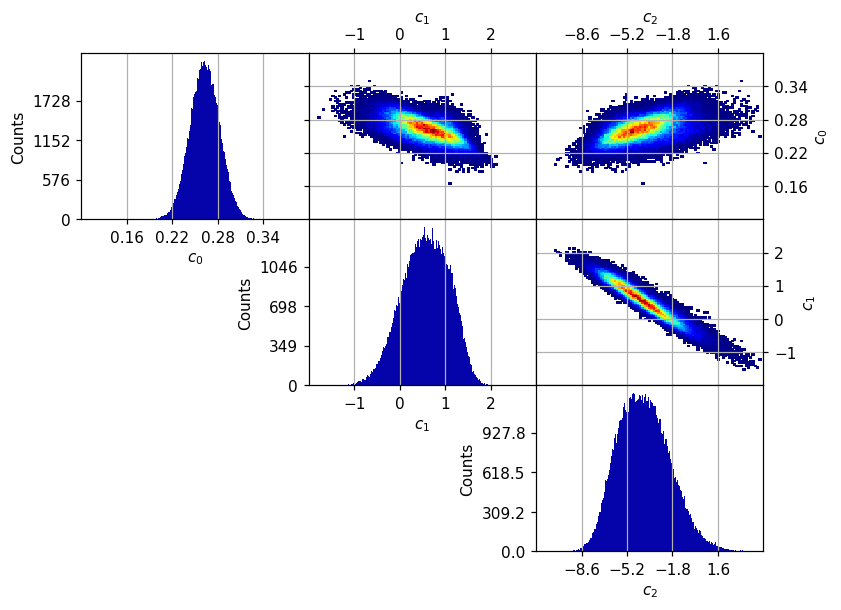

In [17]:
#            c0      c1         c2
ranges = [[0.1, 0.4], [-2, 3], [-12, 5]]

fig = plot.energy_corner_plot(p3_det, ranges)

## 3 - Uniform threshold analysis

The goal of this section is to set the detectir to a series of uniform thresholds in order to investigate variations across the detector.

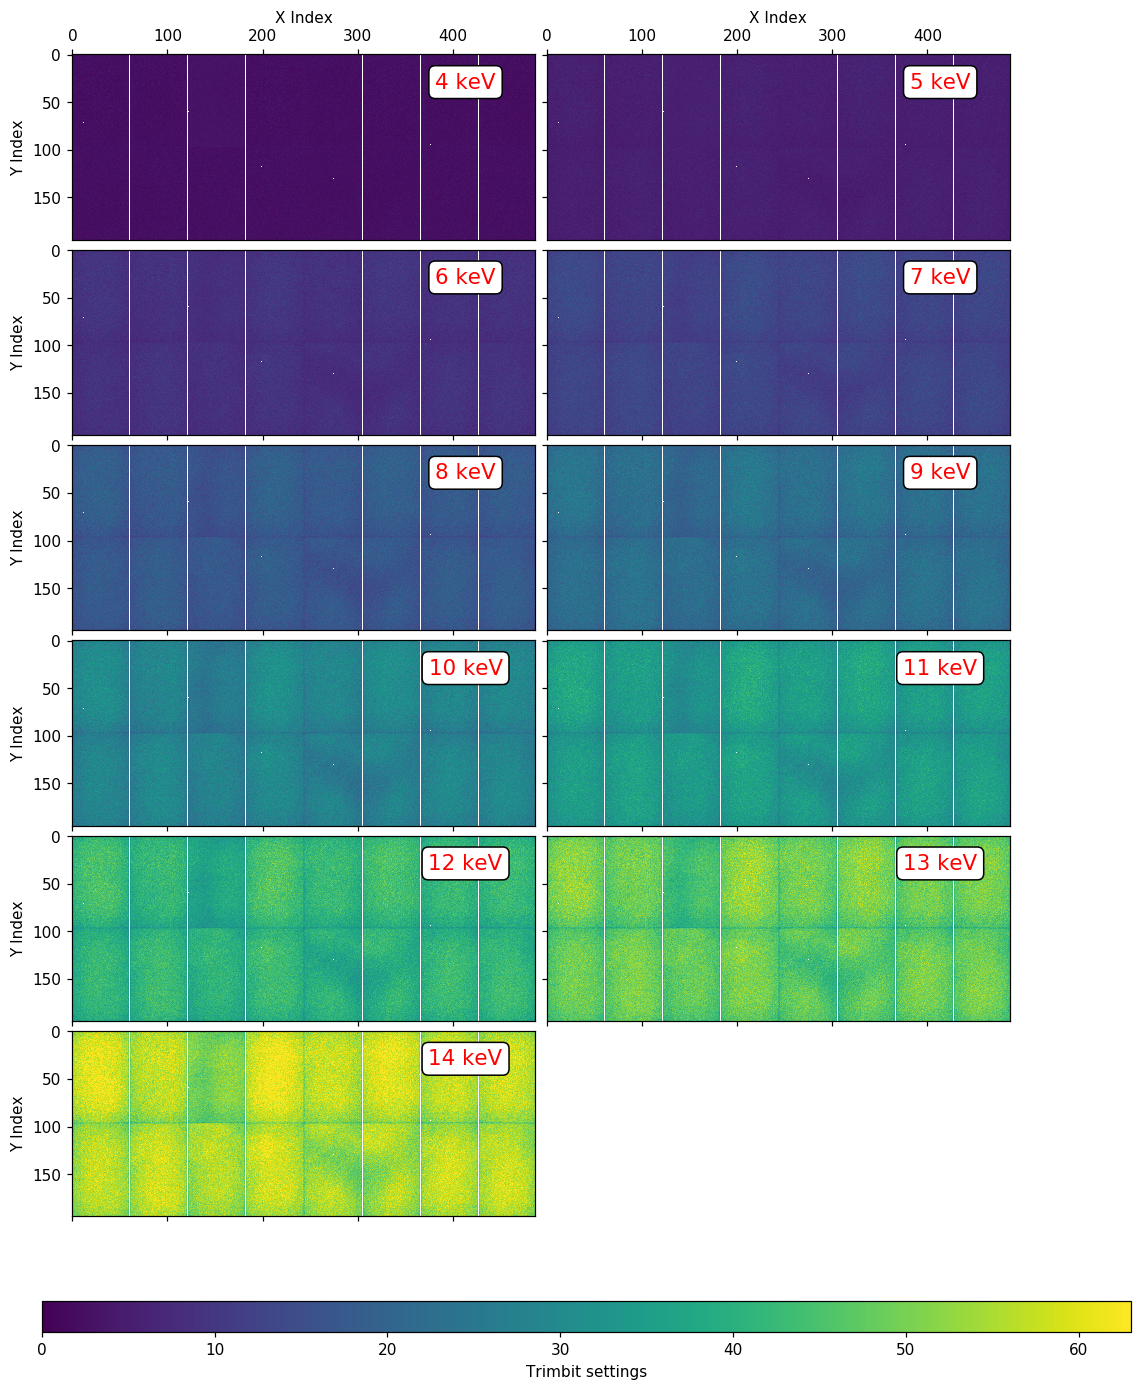

In [18]:
threshold_set = np.arange(4., 15.)
fig = plot.uniform_treshold_trimbit_maps(p3_det, threshold_set, figsize=(11,14))

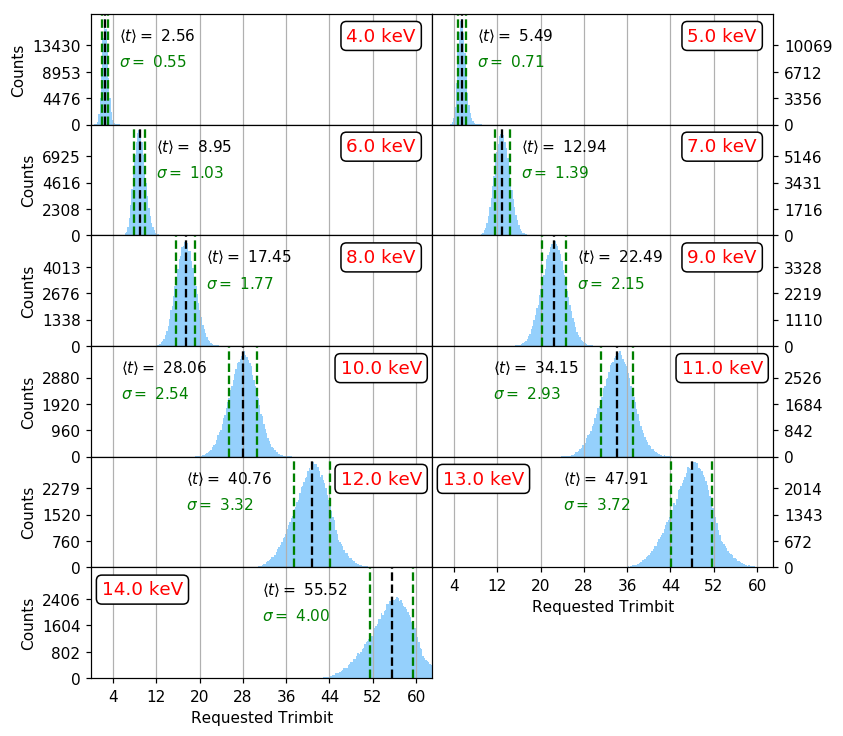

In [19]:
fig = plot.uniform_treshold_trimbit_distributions(p3_det, threshold_set, figsize=(8,8))

The next plot investigates the impact of trimbit rounding on the ability to set a specific threshold across the detector. This can be thought of as a sort of "resolution" to which one can meaningfully set a specific threshold, on average. In practice, this sets a limit to how closely spaced thresholds should be set to one another.

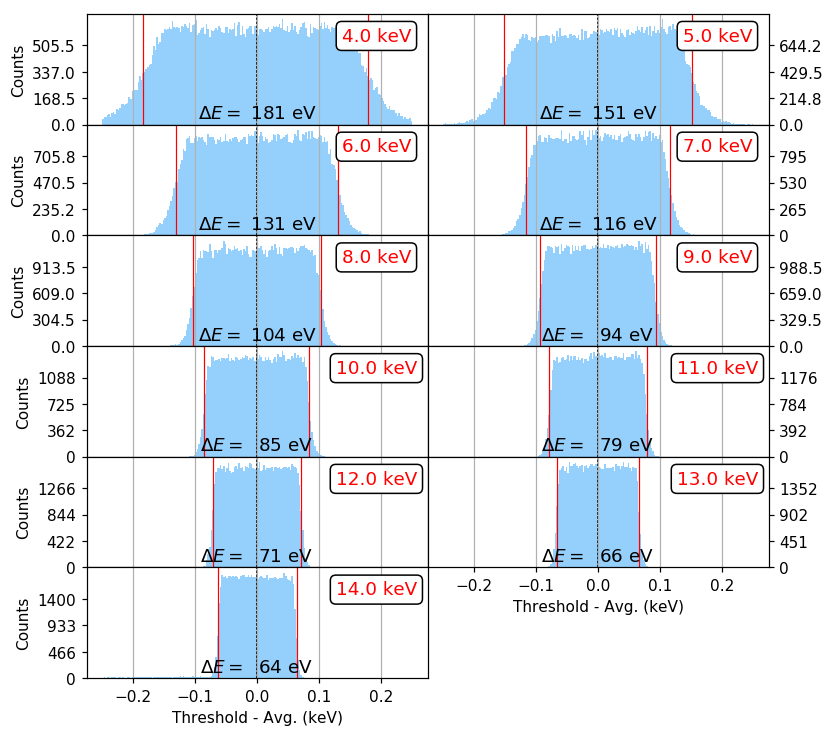

In [20]:
fig, delta_E = plot.uniform_treshold_delta_E(p3_det, threshold_set, figsize=(8,8))

In [21]:
from scipy.interpolate import spline

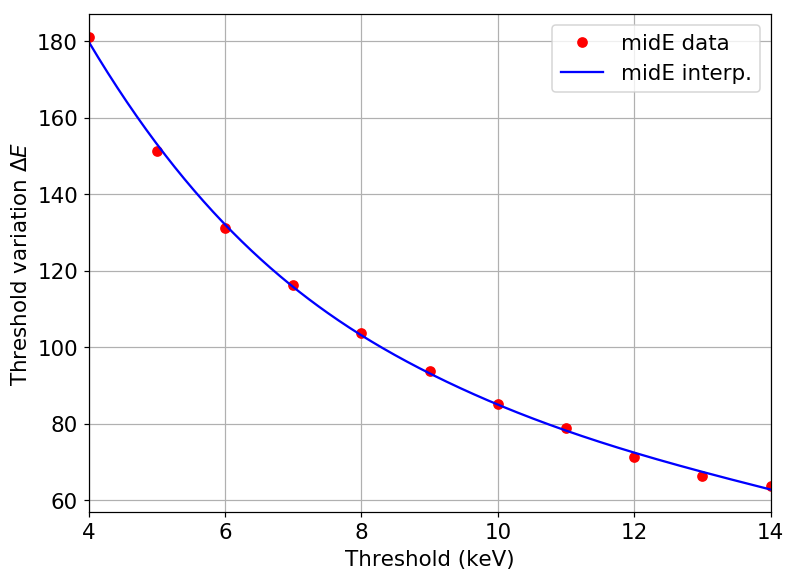

In [22]:
fig = plt.figure(1, figsize=(8,6), dpi=110)
ax = fig.add_subplot(1, 1, 1)
plt.tick_params(labelsize=14)

ax.plot(threshold_set, delta_E, 'o', color='red', label='midE data')

# Smoothed spline fit to illustrate mapping
thresh = np.linspace(np.amin(threshold_set), np.amax(threshold_set), 500)
dE = sp.interpolate.UnivariateSpline(threshold_set, delta_E, k=3)
ax.plot(thresh, dE(thresh), color='blue', label='midE interp.')
ax.set_xlim([np.amin(threshold_set), np.amax(threshold_set)])

# Plot labels
ax.set_xlabel('Threshold (keV)', fontsize=14)
ax.set_ylabel(r'Threshold variation $\Delta E$', fontsize=14)
ax.legend(loc='upper right', fontsize=14)
ax.grid()

## 4 - Comparison to original calibration

In [23]:
import tifffile as tif

Text(0.5,1,'Trimbit settings old vs. new ($E_c = 6.0$ keV)')

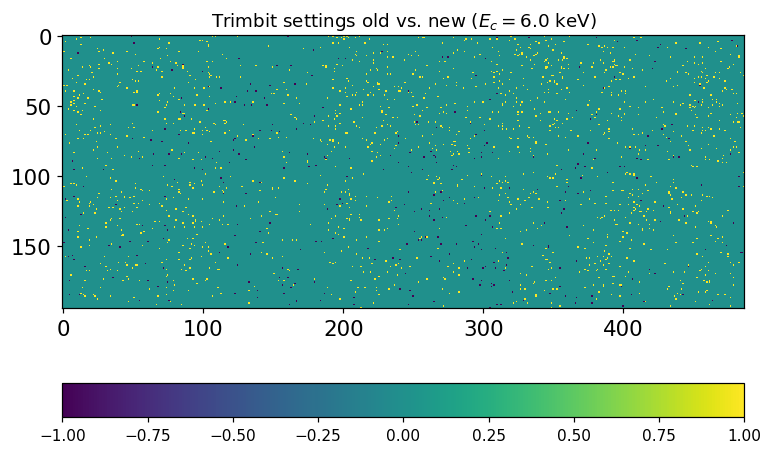

In [24]:
# A basic threshold map for comparison
Ec = 6.0
threshold_map = Ec*np.ones(p3_det.global_pixel_dims)

# Now convert this to trimbit values using the new method
trimbits_new = p3_det.get_trimbit_map(threshold_map)

# Also load old results for the same threshold from file
old_path = '/home/pdvanmeter/data/meSXR/MST/configuration/MST_4_to_12_keV/single_energy_{0:d}p{1:d}'.format(int(Ec), int(Ec*10 - int(Ec)*10))
fname = 'single_energy_{0:d}p{1:d}_trimbit.tif'.format(int(Ec), int(Ec*10 - int(Ec)*10))
trimbits_old = tif.imread(os.path.join(old_path, fname)).T

# Plot the results
fig = plt.figure(1, figsize=(8,6), dpi=110)
ax = fig.add_subplot(1, 1, 1)
plt.tick_params(labelsize=14)

cax = ax.imshow((trimbits_old - trimbits_new).T, vmin=-1, vmax=1)
fig.colorbar(cax, orientation='horizontal')
ax.set_title(r'Trimbit settings old vs. new ($E_c = {0:.1f}$ keV)'.format(Ec))

In [25]:
np.unique(trimbits_new, return_counts=True)

(array([ 0,  6,  7,  8,  9, 10, 11, 12, 13, 14, 23]),
 array([ 1848,   335,  6238, 25551, 34321, 19971,  5697,   902,    96,
            5,     1]))

Text(0.5,1,'Trimbit settings old vs. new ($E_c = 4.0$ keV)')

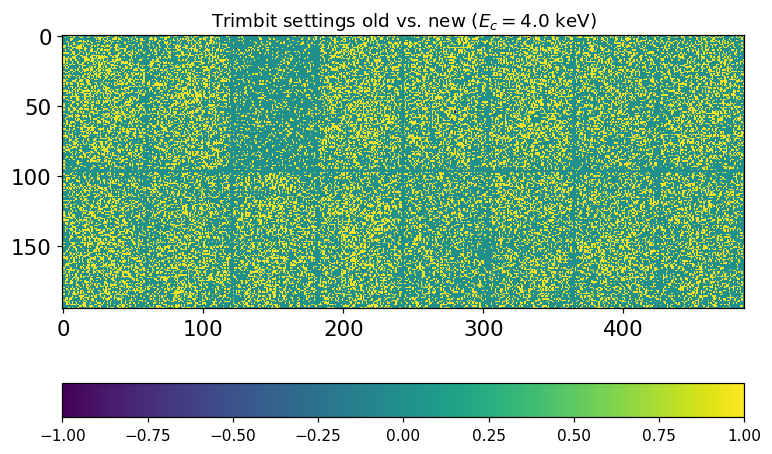

In [26]:
# A basic threshold map for comparison
Ec = 4.0
threshold_map = Ec*np.ones(p3_det.global_pixel_dims)

# Now convert this to trimbit values using the new method
trimbits_new = p3_det.get_trimbit_map(threshold_map)

# Also load old results for the same threshold from file
old_path = '/home/pdvanmeter/data/meSXR/MST/configuration/MST_4_to_12_keV/single_energy_{0:d}p{1:d}'.format(int(Ec), int(Ec*10 - int(Ec)*10))
fname = 'single_energy_{0:d}p{1:d}_trimbit.tif'.format(int(Ec), int(Ec*10 - int(Ec)*10))
trimbits_old = tif.imread(os.path.join(old_path, fname)).T

# Plot the results
fig = plt.figure(1, figsize=(8,6), dpi=110)
ax = fig.add_subplot(1, 1, 1)
plt.tick_params(labelsize=14)

cax = ax.imshow((trimbits_old - trimbits_new).T, vmin=-1, vmax=1)
fig.colorbar(cax, orientation='horizontal')
ax.set_title(r'Trimbit settings old vs. new ($E_c = {0:.1f}$ keV)'.format(Ec))

In [27]:
np.unique(trimbits_old - trimbits_new, return_counts=True)

(array([-19,  -5,  -2,  -1,   0,   1,  14]),
 array([    1,     1,     1,     2, 66717, 28242,     1]))

There is some noticeable difference at low threshold. I am unsure of the reason for this, but it may have something to do with the automatic $\chi^2$ rejection that the old code used to codify a "good fit". Some system like that may ultimately be necessary for the lowE fit, but for this data set it seems like an unnecessary overconstraint. So, it will be interesting to see if this new calibration improves the quality of the data.

## 4.5 - Producing settings files

It was my initial goal to make pickle files which contianed only the results in order to speed up loading/processing speeds when the trimscan data is not needed. However it is clear that what is actually needed is a database. I will try to implement HDF5 support soon. For the time being though I will focus on using existing calibration object to produce the settings and trimbit files necessary to operate the diagnostic.

First up: the autodacs settings file.

In [28]:
# Format the settings into a string with linebreaks
settings = '# /dev/shm/setdacs_b01_m01.dat\n'
settings += 'set B01_M01_VTRM {0: 2.4f}\n'.format(p3_det.settings['VTRM'])

for vcmp in range(p3_det.num_chips):
    vcmp_str = 'VCMP{0:}'.format(vcmp)
    settings += 'set B01_M01_{0:} {1: 2.4f}\n'.format(vcmp_str, p3_det.settings[vcmp_str])

for key in ['VCCA', 'VRF', 'VRFS', 'VCAL', 'VDEL', 'VADJ']:
    settings += 'set B01_M01_{0:} {1: 2.4f}\n'.format(key, p3_det.settings[key])
    
# Remove the final unwanted newline
settings = settings[:-1]

# See if it worked
print(settings)

# /dev/shm/setdacs_b01_m01.dat
set B01_M01_VTRM  1.1495
set B01_M01_VCMP0  0.7935
set B01_M01_VCMP1  0.8105
set B01_M01_VCMP2  0.7572
set B01_M01_VCMP3  0.7838
set B01_M01_VCMP4  0.8226
set B01_M01_VCMP5  0.8105
set B01_M01_VCMP6  0.7790
set B01_M01_VCMP7  0.8008
set B01_M01_VCMP8  0.8056
set B01_M01_VCMP9  0.8081
set B01_M01_VCMP10  0.8202
set B01_M01_VCMP11  0.8032
set B01_M01_VCMP12  0.7863
set B01_M01_VCMP13  0.8177
set B01_M01_VCMP14  0.8032
set B01_M01_VCMP15  0.7887
set B01_M01_VCCA  0.8008
set B01_M01_VRF -0.1003
set B01_M01_VRFS  0.9001
set B01_M01_VCAL  0.6506
set B01_M01_VDEL  0.6288
set B01_M01_VADJ  1.1543


In [29]:
Ec = 6.0
threshold_map = Ec*np.ones(p3_det.global_pixel_dims)

filepath = '/home/pdvanmeter/analysis/python/mesxr_dev/test_config'
#p3_det.write_settings_file(filepath)
#p3_det.write_autotrim_files(threshold_map, filepath)
#p3_det.write_bad_pixels_file(filepath)

## 5 - Bad pixel investigation

I also want to take a look at the "bad pixels." Does this calibration adequately catch them? It should print out a file containing these pixels so that the operation/data processing code can identify them without loading in the full calibration.

In [30]:
num_bad_pix = 0
bad_pix_coords = []

for pixel in p3_det.pixels.ravel():
    if not pixel.good_enfit and type(pixel) != calib.Pilatus_Null_Pixel:
        num_bad_pix += 1
        bad_pix_coords.append(pixel.coords)

In [31]:
print('Number of bad pixels identified: {0:}'.format(num_bad_pix))
for coords in bad_pix_coords:
    print(str(coords))

Number of bad pixels identified: 5
(12, 71)
(122, 60)
(198, 117)
(274, 130)
(376, 94)


From my previous work I expected to find: (333, 2), (280, 55), (12, 71), (376, 94), and (198, 117). Two of these have been identified by the calibration code. I suspect the other three were really more of a problem for the lowE calibration data than for the midE data. In fact, we can briefly investigate this claim now. This investigation will let us know whether we should trust the code to identify all bad pixels automatically or whether some room should be left for human input.

First, the pixels found to be bad by the calibration:

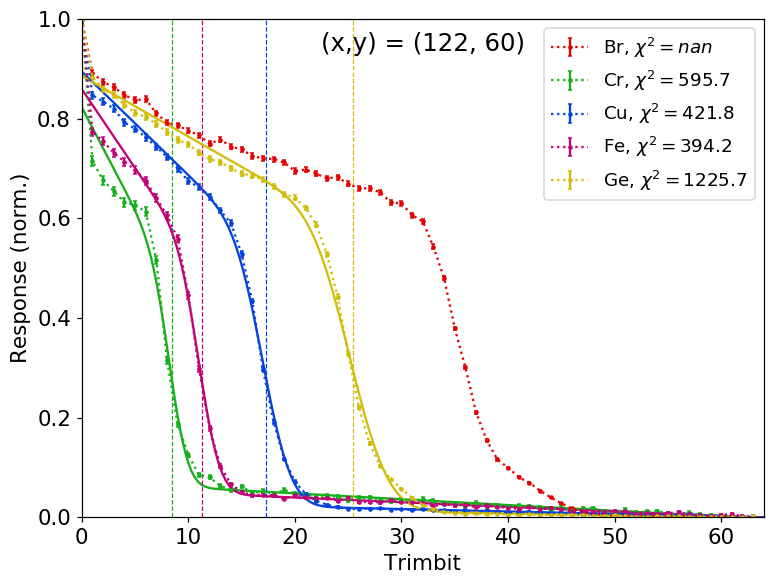

In [32]:
fig = plot.s_curves_plot(p3_det, 122, 60)

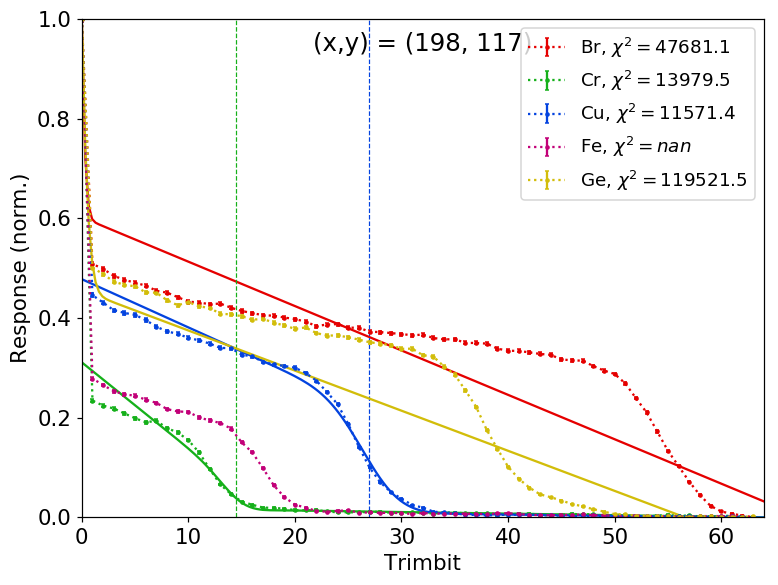

In [33]:
fig = plot.s_curves_plot(p3_det, 198, 117)

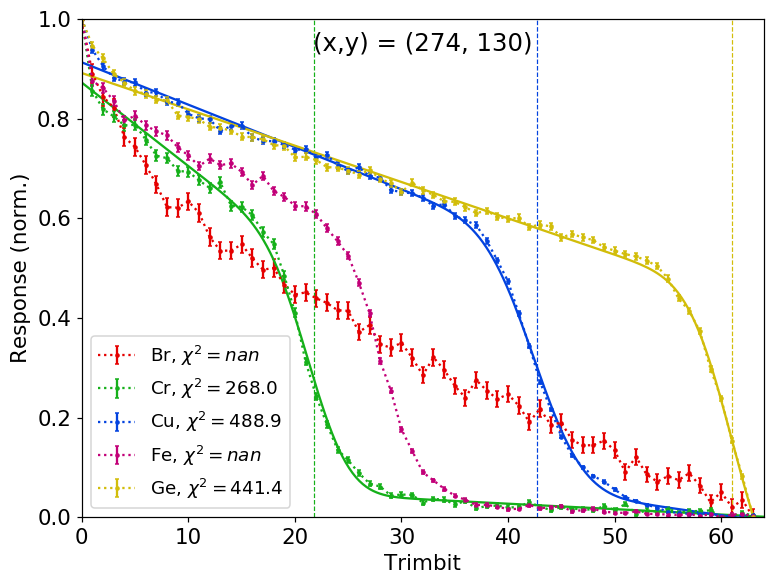

In [34]:
fig = plot.s_curves_plot(p3_det, 274, 130)

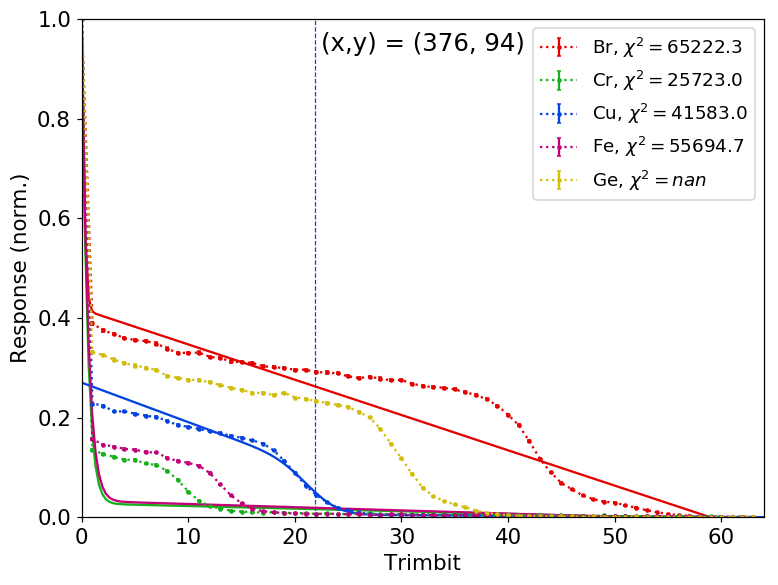

In [35]:
fig = plot.s_curves_plot(p3_det, 376, 94)

Clearly the code is right in marking these pixels as problematic. Now, let's look at the remaining three that I had previously marked as bad:

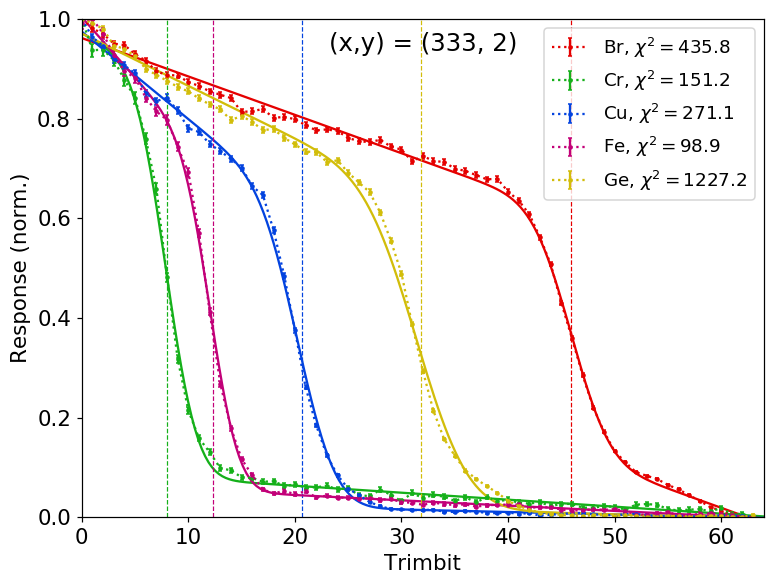

In [36]:
fig = plot.s_curves_plot(p3_det, 333, 2)

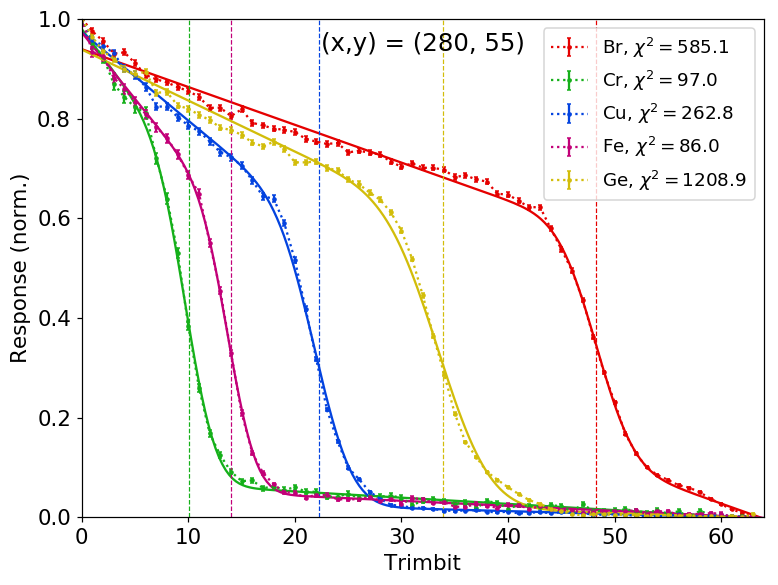

In [37]:
fig = plot.s_curves_plot(p3_det, 280, 55)

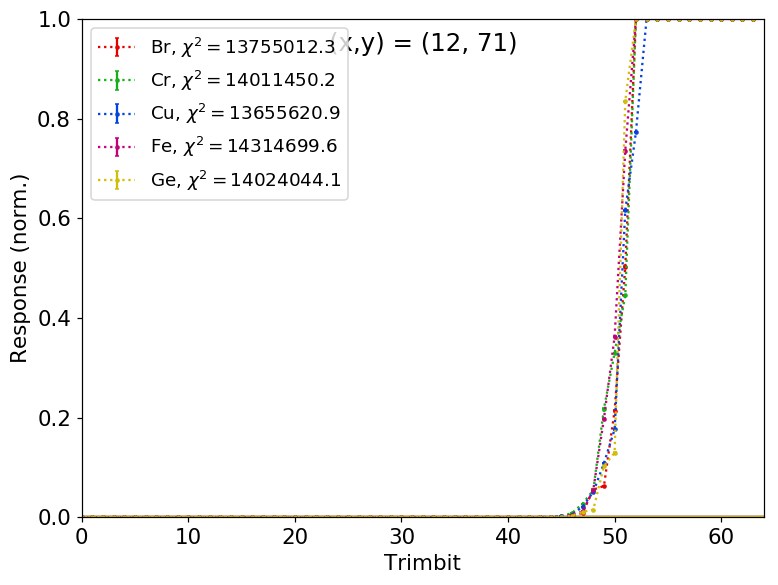

In [38]:
fig = plot.s_curves_plot(p3_det, 12, 71)

It seems that these are mostly fine except for (12,71) which produced a "fit" for some reason. It seems that I will probably want to go with a mixed model which automatically marks bad fits based on the calibration but also allows for additional pixels to be manually marked.

_Note: The pixel (12,71) now appears in the bad pixel list because it was manually added at the top of the notebook._

## 6 - A phenomenological look at charge-sharing

As a reminder, data was fit to the S-curve equation defined by:

$N(\hat{t}) = \frac{1}{2} \bigg[erf(-\frac{\hat{t} - a_0}{\sqrt{2} a_1}) + 1\bigg] \cdot \big(a_2 + a_3 (\hat{t} - a_0)\big) + a_4 + a_5 (\hat{t} - a_0)$

Charge sharing due to the primary emission line was characterized by the parameter $a_3$, which has units of photon/trimbit ($\gamma/tb$). The parameter $a_5$ describes charge sharing due to the background (other excited lines). However since the properties of these background lines are not well known _a priori_ it is best to focus on $a_3$. So to start with we will look at the scaling of this parameter, first in trimbit space and then (more physically) in energy space.

From the earlier plots we know that $a_3$ follows a fairly gaussian distribution. We will start here by characterizing the base behavior, including an investigation into whether the effect varies significantly by chip number.

In [39]:
def get_a3_set(elem, mode='all'):
    # Loop through pixels and sort into two data sets, one by chip and one including all valid fits
    a3_chip = {i:[] for i in range(16)}
    a3_all = []

    for pixel in p3_det.pixels.ravel():
        if pixel.good_enfit:
            if mode == 'all':
                index = pixel.elements.index(elem)
                if pixel.good_trimfits[index]:
                    a3 = pixel.trimfit_params[index, 3]
                    if a3 > -1e4:
                        a3_chip[pixel.chip].append(a3)
                        a3_all.append(a3)
                        
            elif mode == 'edge':
                index = pixel.elements.index(elem)
                if pixel.good_trimfits[index] and pixel.edge_pixel:
                    a3 = pixel.trimfit_params[index, 3]
                    if a3 > -1e4:
                        a3_chip[pixel.chip].append(a3)
                        a3_all.append(a3)
                            
            elif mode == 'core':
                index = pixel.elements.index(elem)
                if pixel.good_trimfits[index] and not pixel.edge_pixel:
                    a3 = pixel.trimfit_params[index, 3]
                    if a3 > -1e4:
                        a3_chip[pixel.chip].append(a3)
                        a3_all.append(a3)
                    
    return a3_all, a3_chip

def plot_elem_dist(elem, mode='all'):
    a3_all, a3_chip = get_a3_set(elem, mode=mode)
                
    fig = plt.figure(1, figsize=(8,6), dpi=110)
    ax = fig.add_subplot(1, 1, 1)
    plt.tick_params(labelsize=14)

    hist, bins, patches = ax.hist(a3_all, bins=250, color='xkcd:light blue', density=True)

    # Extra stats
    a3_mean = np.average(a3_all)
    a3_stdev = np.std(a3_all)

    ax.axvline(x=a3_mean, color='xkcd:red', linestyle='--', linewidth=1.2, label=r'$\langle a_3 \rangle = {0:.1f}$'.format(a3_mean))
    ax.axvline(x=a3_mean+a3_stdev, color='xkcd:green', linestyle='--', linewidth=1.2, label=r'$\sigma(a_3) = {0:.1f}$'.format(a3_stdev))
    ax.axvline(x=a3_mean-a3_stdev, color='xkcd:green', linestyle='--', linewidth=1.2)

    ax.legend(loc='upper left', fontsize=14)
    ax.set_xlabel(r'Pixel CS slope $a_3$ ($\delta$photons / $\delta \hat{t}$)', fontsize=14)
    ax.set_ylabel(r'Observed distribution $p(a_3)$', fontsize=14)
    
    ax.text(0.1, 0.1, elem, horizontalalignment='center', verticalalignment='center',
            transform = ax.transAxes, fontsize=18, color='red',
            bbox=dict(facecolor='none', edgecolor='black', fc='w', boxstyle='round'))
    
    if mode =='edge':
        ax.text(0.5, 0.95, 'Edge only', horizontalalignment='center', verticalalignment='center',
            transform = ax.transAxes, fontsize=14, color='black')
    elif mode == 'core':
        ax.text(0.5, 0.95, 'Core only', horizontalalignment='center', verticalalignment='center',
            transform = ax.transAxes, fontsize=14, color='black')
    
    return fig

def chip_a3_plot(elem, exclude_edge=False, mode='all'):
    a3_all, a3_chip = get_a3_set(elem, mode=mode)
                
    fig = plt.figure(1, figsize=(8,6), dpi=110)
    ax = fig.add_subplot(1, 1, 1)
    plt.tick_params(labelsize=14)

    for chip in range(16):
        a3 = a3_chip[chip]
        ax.plot(chip*np.ones(len(a3)), a3, linestyle='none', marker='o', alpha=0.05, color='xkcd:blue')

        avg = np.average(a3)
        std = np.std(a3)
        ax.errorbar(chip, avg, yerr=std, capsize=6, ms=5, marker='o', linestyle=':', color='xkcd:orange', zorder=100)

    ax.set_xlabel('Chip number', fontsize=14)
    ax.set_ylabel(r'Pixel CS slope $a_3$ ($\delta$photons / $\delta \hat{t}$)', fontsize=14)
    ax.set_ylim([avg-7*std, avg+7*std])

    ax.text(0.9, 0.9, elem, horizontalalignment='center', verticalalignment='center',
            transform = ax.transAxes, fontsize=18, color='red',
            bbox=dict(facecolor='none', edgecolor='black', fc='w', boxstyle='round'))
    
    if mode =='edge':
        ax.text(0.5, 0.95, 'Edge only', horizontalalignment='center', verticalalignment='center',
            transform = ax.transAxes, fontsize=14, color='black')
    elif mode == 'core':
        ax.text(0.5, 0.95, 'Core only', horizontalalignment='center', verticalalignment='center',
            transform = ax.transAxes, fontsize=14, color='black')
    
    return fig

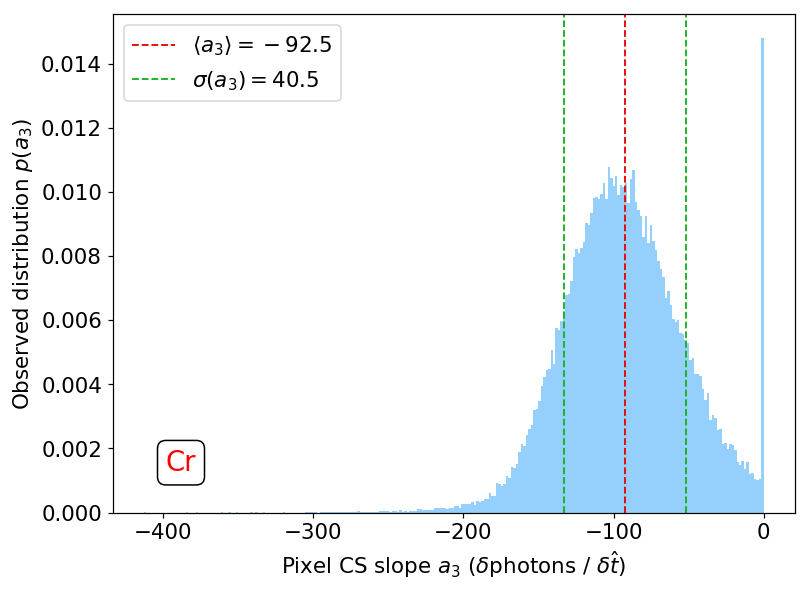

In [40]:
fig = plot_elem_dist('Cr')

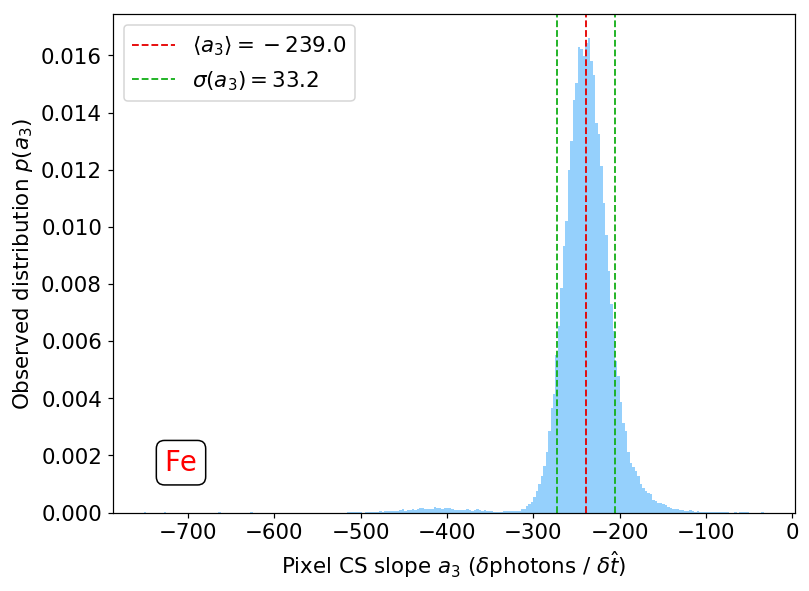

In [41]:
fig = plot_elem_dist('Fe')

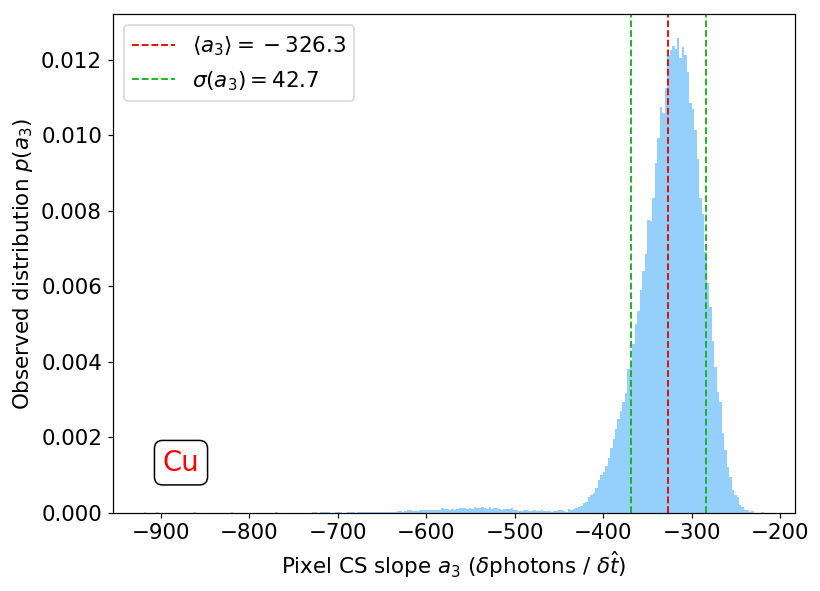

In [42]:
fig = plot_elem_dist('Cu')

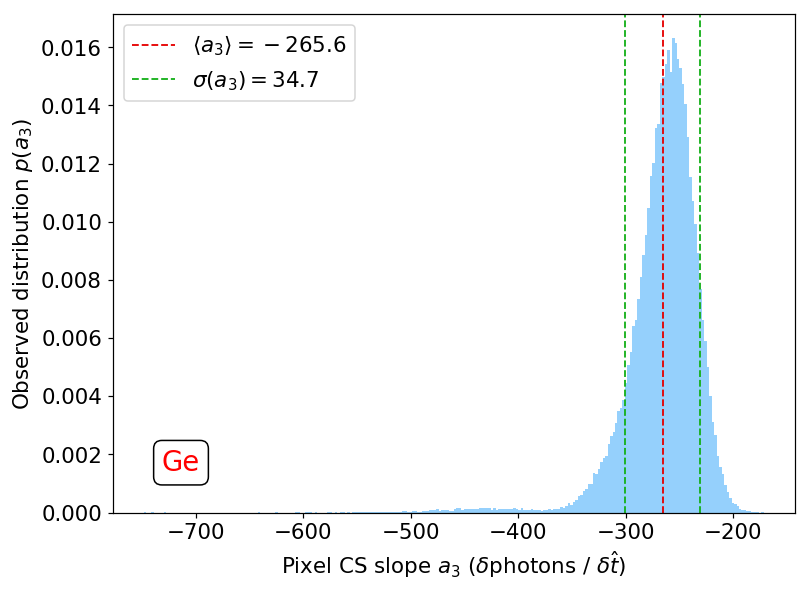

In [43]:
fig = plot_elem_dist('Ge')

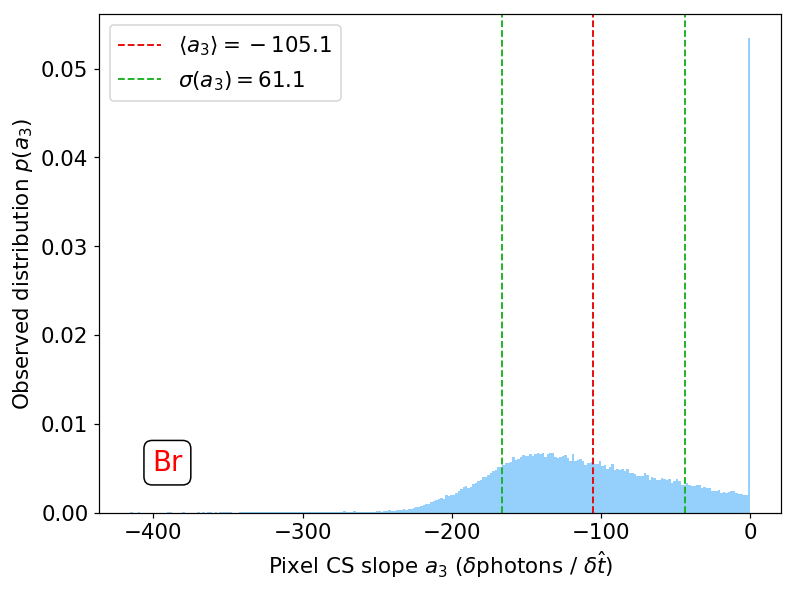

In [44]:
fig = plot_elem_dist('Br')

Now breaking it down by chip:

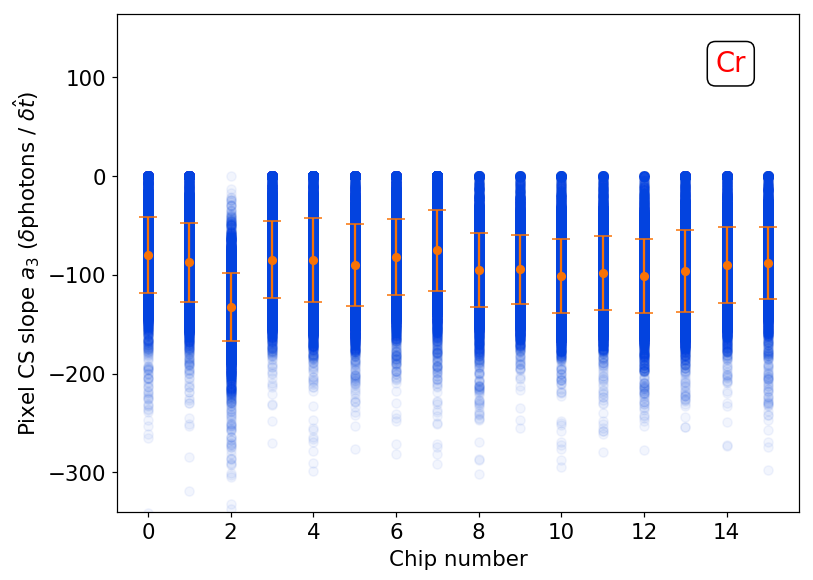

In [45]:
fig = chip_a3_plot('Cr')

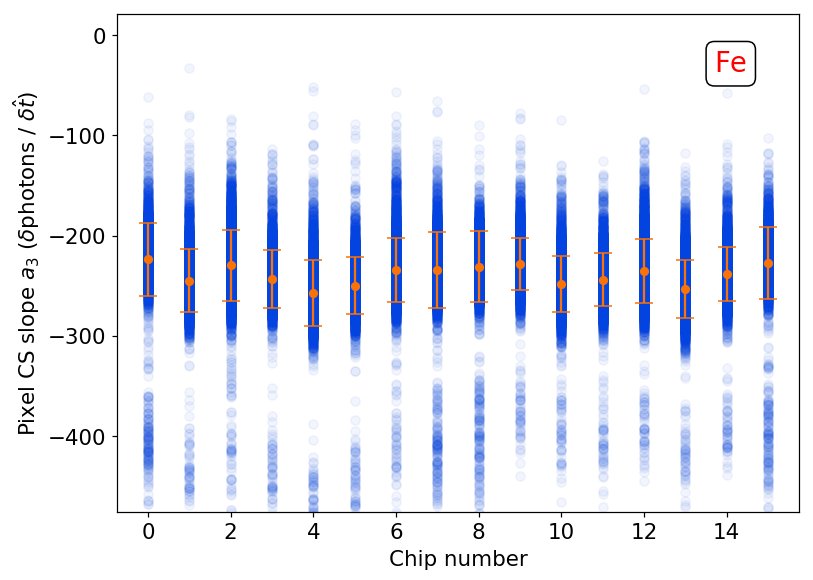

In [46]:
fig = chip_a3_plot('Fe')

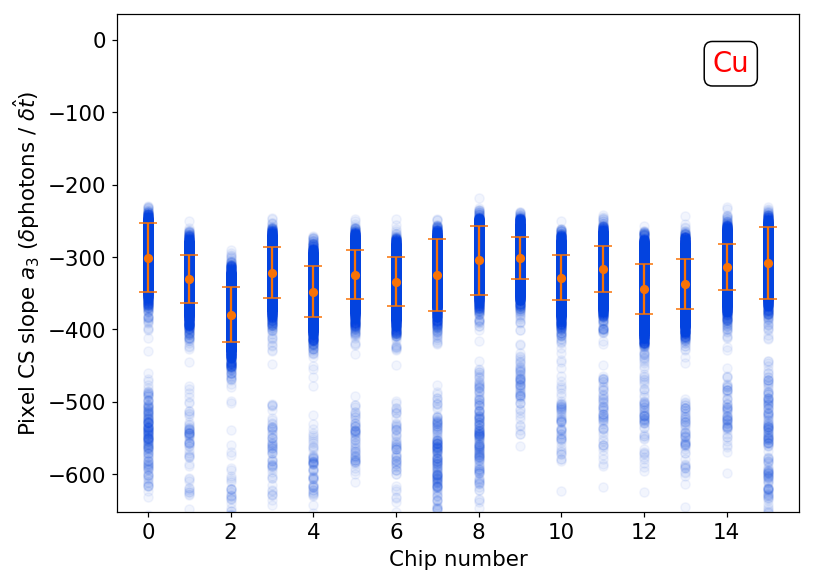

In [47]:
fig = chip_a3_plot('Cu')

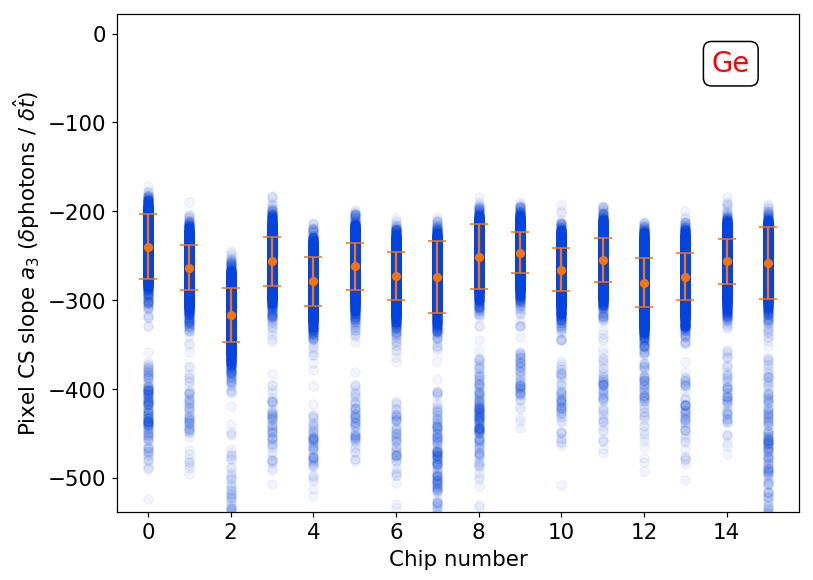

In [48]:
fig = chip_a3_plot('Ge')

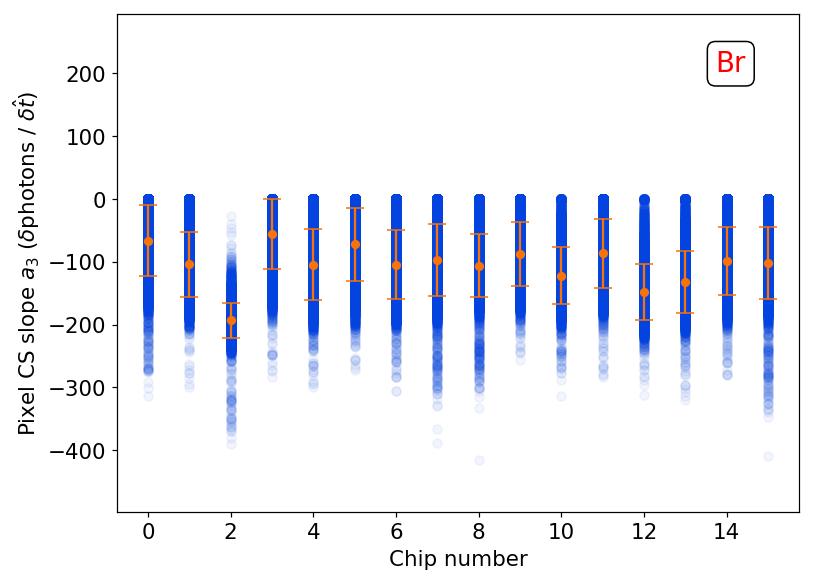

In [49]:
fig = chip_a3_plot('Br')

It is notable that most cases show a bimodal distribution, with a substantial bump in the tail at a value of $a_3$ that is lower (more negative) than the mean value. It is my hypothesis that this second population is made up of edge pixels. Now I will test that hypothesis.

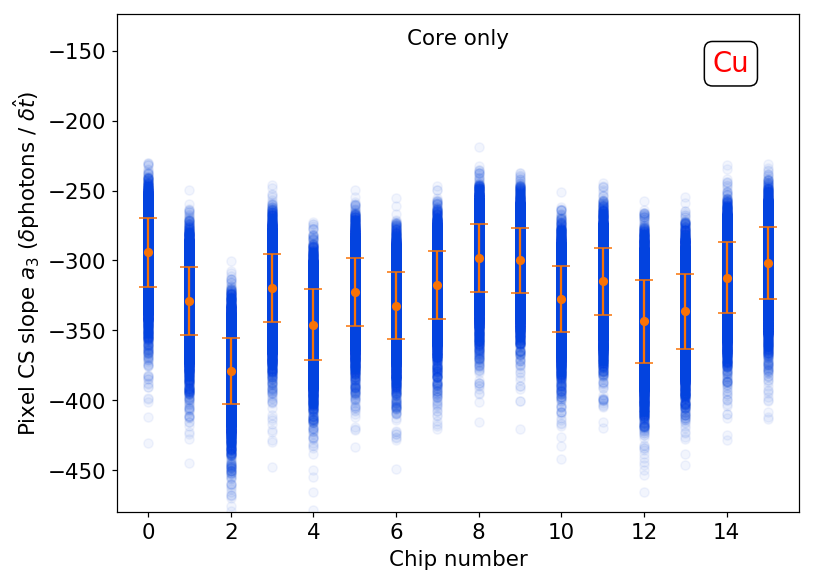

In [50]:
fig = chip_a3_plot('Cu', mode='core')

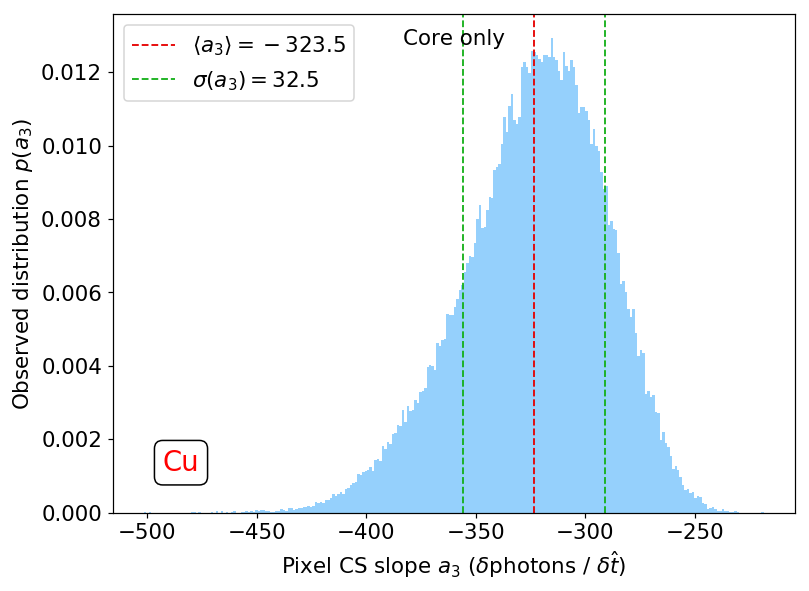

In [51]:
fig = plot_elem_dist('Cu', mode='core')

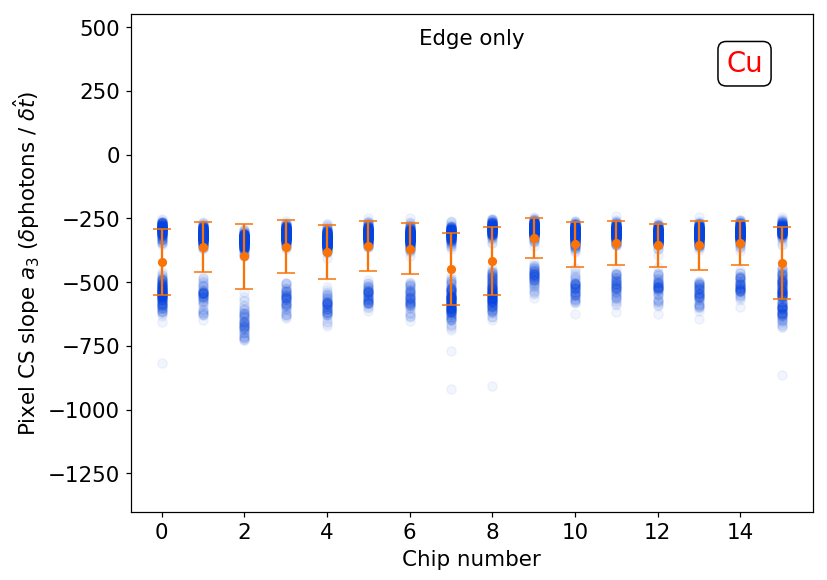

In [52]:
fig = chip_a3_plot('Cu', mode='edge')

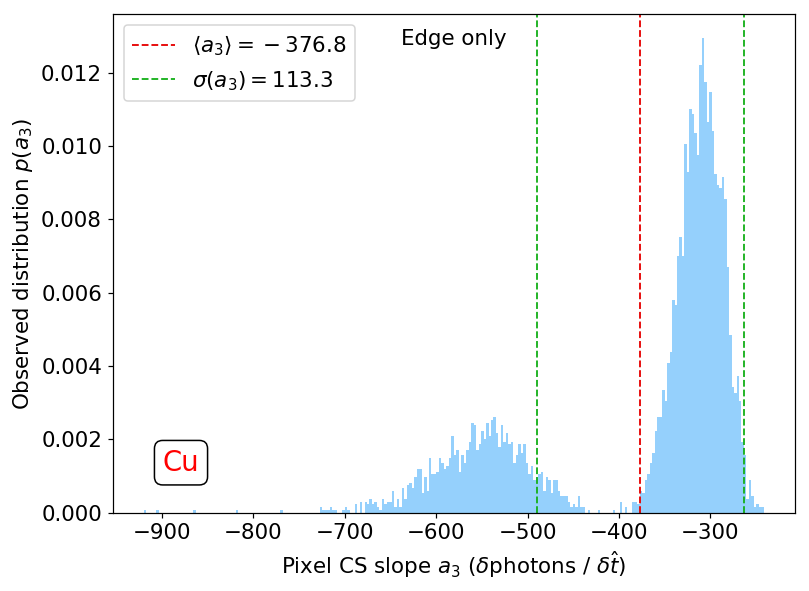

In [53]:
fig = plot_elem_dist('Cu', mode='edge')

This confirms my hypothesis. Some edge pixels, probably those that are actually along the detector outer edge which are not actually enlarged, have the same $\langle a_3 \rangle$ as the bulk core pixels. The enlarged pixels, on the other had, have a different distribution with a more negative slope. This may come in useful later when validating a charge-sharing model.

Now, we want to look at the scaling of $\langle a_3 \rangle$ vs the incident photon energy.

In [54]:
elements = ['Cr', 'Fe', 'Cu', 'Ge', 'Br']
en_in = util.get_line_energy(elements)
a3_avg = np.zeros(len(en_in))
a3_std = np.zeros(len(en_in))

for index, elem in enumerate(elements):
    a3_set = get_a3_set(elem, mode='core')[0]
    a3_avg[index] = np.average(a3_set)
    a3_std[index] = np.std(a3_set)

Text(0,0.5,'Pixel CS slope $\\langle a_3 \\rangle$ ($\\delta$photons / $\\delta \\hat{t}$)')

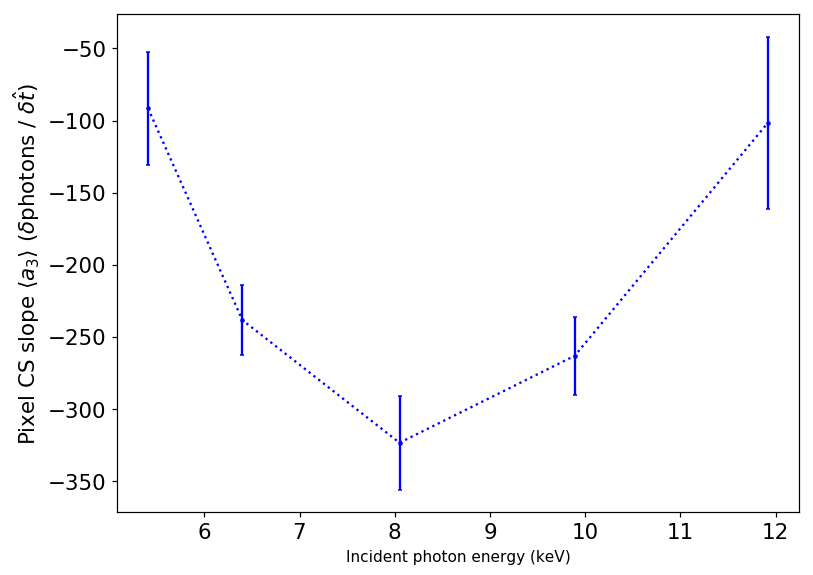

In [55]:
fig = plt.figure(1, figsize=(8,6), dpi=110)
ax = fig.add_subplot(1, 1, 1)
plt.tick_params(labelsize=14)

ax.errorbar(en_in, a3_avg, yerr=a3_std, capsize=1, ms=2, marker='o', linestyle=':', color='blue')
ax.set_xlabel('Incident photon energy (keV)')
ax.set_ylabel(r'Pixel CS slope $\langle a_3 \rangle$ ($\delta$photons / $\delta \hat{t}$)', fontsize=14)

In order to make this physically meaningful, we should scale the values of $\langle a_3 \rangle$ by it's derivative. Recall that the trimbit fit is given by:

$\hat{t}(E_c) = c_0 E_c^2 + c_1 E_c + c_2$

The charge sharing slope term defined in the S-curve equation can be taken to behave like

$a_3 = \frac{\delta \gamma}{\delta \hat{t}}$

in the region where the error function is nearly equal to one (here I am using the symbol $\gamma$ to mean "number of photons"). However we want a version of this slope cast into more physically meaningful threshold energy units:

$\tilde{a}_3 \equiv \frac{\delta \gamma}{\delta E_c} = \frac{\delta \gamma}{\delta \hat{t}} \frac{\delta \hat{t}}{\delta E_c} \approx a_3 \cdot \frac{d\hat{t}}{d E_c}$

Giving a simple equation for the scaled energy-dependent charge-sharing slope:

$\Rightarrow \tilde{a}_3 \approx a_3 \cdot \frac{d\hat{t}}{d E_c} = a_3 \cdot \big( 2 c_0 E_c + c_1 \big)$

In [56]:
c0, c1, c2 = p3_det.pixels[120,20].enfit_params
-250.0*(2*c0*np.linspace(4, 8, num=10) + c1)

array([ -539.586724  ,  -600.78060691,  -661.97448982,  -723.16837273,
        -784.36225564,  -845.55613855,  -906.75002147,  -967.94390438,
       -1029.13778729, -1090.3316702 ])

I want to try remapping the S-curve to depend on $Ec$ rather than on the trimbit:

In [69]:
def en_s_curve(Ec, b0, b1, b2, b3, b4, b5):
    return 0.5*sp.special.erfc((Ec - b0)/(np.sqrt(2)*b1))*(b2 + b3*(Ec - b0)) + (b4 + b5*(Ec - b0))

Text(0.82,0.6,'26.8 % diff')

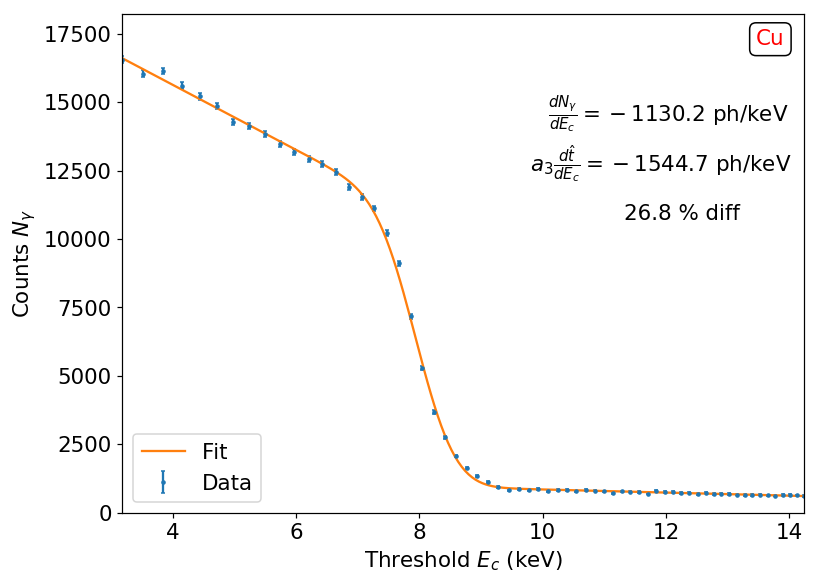

In [82]:
coords = (100, 50)
elem = 'Cu'

# Make the plot
fig = plt.figure(1, figsize=(8,6), dpi=110)
ax = fig.add_subplot(1, 1, 1)
plt.tick_params(labelsize=14)

elem_index = p3_det.pixels[coords].elements.index(elem)
tbits = p3_det.pixels[coords].trimbits[elem_index]
Ec = p3_det.pixels[coords].threshold_from_trimbit(np.arange(64))
counts = p3_det.pixels[coords].data[elem_index]

ax.errorbar(Ec, counts, yerr=np.sqrt(counts), capsize=1, ms=2, marker='o', linestyle='none', label='Data')

ax.set_xlabel(r'Threshold $E_c$ (keV)', fontsize=14)
ax.set_ylabel('Counts $N_\gamma$', fontsize=14)
ax.set_xlim([Ec[0], Ec[-1]])
ax.set_ylim([0, 1.1*max(counts)])

# Fit the data to an energy S-curve
p0 = [8.0, 1.0, np.amax(counts), 0.0, np.amin(counts), 0.0]
bounds = (np.array([-np.inf,  -np.inf, -np.inf, -np.inf, -np.inf, -np.inf]),   # Lower bounds
          np.array([ np.inf,   np.inf,  np.inf,  0.0,     np.inf,  0.0]))      # Upper bounds
params, cov = sp.optimize.curve_fit(en_s_curve, Ec, counts, p0=p0, bounds=bounds, sigma=np.sqrt(counts), absolute_sigma=True)

# Also pull the parameter from the original fit
a3 = p3_det.pixels[coords].trimfit_params[elem_index, 3]
c0, c1, c2 = p3_det.pixels[coords].enfit_params
E0 = p3_det.pixels[coords].energies[elem_index]
dt_dEc = 2*c0*E0 + c1
b3_deriv = a3*dt_dEc

# Plot the fit and associated parameters
Ec_model = np.linspace(Ec[0], Ec[-1], num=200)
ax.plot(Ec_model, en_s_curve(Ec_model, *params), label='Fit')

ax.legend(loc='lower left', fontsize=14)
ax.text(0.95, 0.95, elem, horizontalalignment='center', verticalalignment='center',
        transform = ax.transAxes, fontsize=14, color='red',
        bbox=dict(facecolor='none', edgecolor='black', fc='w', boxstyle='round'))

ax.text(0.8, 0.8, r'$\frac{{d N_\gamma}}{{d E_c}} = {0:.1f}$ ph/keV'.format(params[3]), horizontalalignment='center', verticalalignment='center',
        transform = ax.transAxes, fontsize=14, color='black')
ax.text(0.79, 0.7, r'$a_3 \frac{{d \hat{{t}}}}{{d E_c}} = {0:.1f}$ ph/keV'.format(b3_deriv), horizontalalignment='center', verticalalignment='center',
        transform = ax.transAxes, fontsize=14, color='black')

prec_diff = 100.0*np.abs( (params[3] - b3_deriv)/ b3_deriv )
ax.text(0.82, 0.6, '{0:.1f} % diff'.format(prec_diff), horizontalalignment='center', verticalalignment='center',
        transform = ax.transAxes, fontsize=14, color='black')

In [83]:
params[1]

0.5004866873837135

In [122]:
k_cs = np.zeros(len(p3_det.pixels[coords].elements))
k_err= np.zeros(len(p3_det.pixels[coords].elements)) 
E_in = np.zeros(len(p3_det.pixels[coords].elements))
Ew   = np.zeros(len(p3_det.pixels[coords].elements))
elem = np.array(['' for k in k_cs])

# Let's do this for all the pixels and get the normalized slope k_cs
for elem_index in range(len(p3_det.pixels[coords].elements)):
    # Load the data
    tbits = p3_det.pixels[coords].trimbits[elem_index]
    Ec = p3_det.pixels[coords].threshold_from_trimbit(np.arange(64))
    counts = p3_det.pixels[coords].data[elem_index]
    
    # Do the fit
    p0 = [8.0, 1.0, np.amax(counts), 0.0, np.amin(counts), 0.0]
    bounds = (np.array([-np.inf,  -np.inf, -np.inf, -np.inf, -np.inf, -np.inf]),   # Lower bounds
              np.array([ np.inf,   np.inf,  np.inf,  0.0,     np.inf,  0.0]))      # Upper bounds
    params, cov = sp.optimize.curve_fit(en_s_curve, Ec, counts, p0=p0, bounds=bounds, sigma=np.sqrt(counts), absolute_sigma=True)

    # Extract the results
    k_cs[elem_index] = -1.0*params[3] / params[2]
    E_in[elem_index] = p3_det.pixels[coords].energies[elem_index]
    Ew[elem_index]   = params[3]
    elem[elem_index] = p3_det.pixels[coords].elements[elem_index]
    
    k_err[elem_index]=  (1/params[2]**2)*(cov[3,3] + ((params[3]/params[2])**2)*cov[2,2] - 2.0*(params[3]/params[2])*cov[2,3])
    
# Sort the data
sort_n = np.argsort(E_in)
k_cs  = k_cs[sort_n]
k_err = k_err[sort_n]
E_in  = E_in[sort_n]
Ew    = Ew[sort_n]
elem  = elem[sort_n]

Text(0,0.5,'Pixel CS slope $k_{cs}(E_0)$')

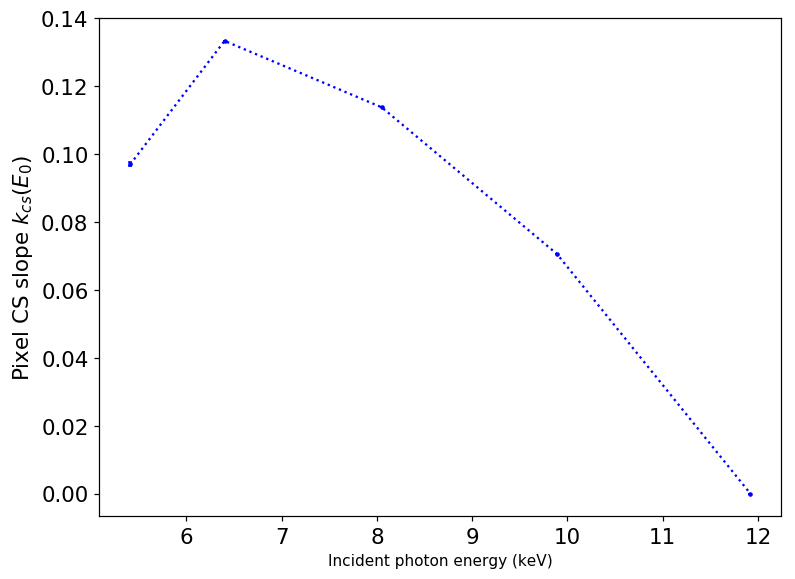

In [117]:
fig = plt.figure(1, figsize=(8,6), dpi=110)
ax = fig.add_subplot(1, 1, 1)
plt.tick_params(labelsize=14)

ax.errorbar(E_in, k_cs, yerr=k_err, capsize=1, ms=2, marker='o', linestyle=':', color='blue')
ax.set_xlabel('Incident photon energy (keV)')
ax.set_ylabel(r'Pixel CS slope $k_{cs}(E_0)$', fontsize=14)

In [123]:
elements

['Cr', 'Fe', 'Cu', 'Ge', 'Br']

Next: get the statistics of this parameter across the detector

In [4]:
def en_s_curve(Ec, b0, b1, b2, b3, b4, b5):
    return 0.5*sp.special.erfc((Ec - b0)/(np.sqrt(2)*b1))*(b2 + b3*(Ec - b0)) + (b4 + b5*(Ec - b0))

In [84]:
elements = ['Cr', 'Fe', 'Cu', 'Ge', 'Br']

k_cs = np.zeros([len(elements), p3_det.global_pixel_dims[0], p3_det.global_pixel_dims[1]])
k_err= np.zeros([len(elements), p3_det.global_pixel_dims[0], p3_det.global_pixel_dims[1]])
Ew   = np.zeros([len(elements), p3_det.global_pixel_dims[0], p3_det.global_pixel_dims[1]])

good_k_fit = np.ones([len(elements), p3_det.global_pixel_dims[0], p3_det.global_pixel_dims[1]])

# Let's do this for all the pixels and get the normalized slope k_cs
for x in range(p3_det.global_pixel_dims[0]):
    for y in range(p3_det.global_pixel_dims[1]):
        coords = (x, y)
        if p3_det.pixels[coords].good_enfit:
            for index, elem in enumerate(elements):
                if elem in p3_det.pixels[coords].elements:
                    # Load the data, if it is a good fit
                    elem_index = p3_det.pixels[coords].elements.index(elem)
                    if p3_det.pixels[coords].good_trimfits[elem_index]:
                        tbits = p3_det.pixels[coords].trimbits[elem_index]
                        Ec = p3_det.pixels[coords].threshold_from_trimbit(np.arange(64))
                        counts = p3_det.pixels[coords].data[elem_index]

                        # Do the fit
                        try:
                            p0 = [8.0, 1.0, np.amax(counts), 0.0, np.amin(counts), 0.0]
                            bounds = (np.array([-np.inf,  -np.inf, -np.inf, -np.inf, -np.inf, -np.inf]),   # Lower bounds
                                      np.array([ np.inf,   np.inf,  np.inf,  0.0,     np.inf,  0.0]))      # Upper bounds
                            params, cov = sp.optimize.curve_fit(en_s_curve, Ec, counts, p0=p0, bounds=bounds, sigma=np.sqrt(counts), absolute_sigma=True)

                        except:
                            # Bad fit - mark it down
                            good_k_fit[index, x, y] = False
                            
                        else:
                            # Extract the results
                            k_cs[index, x, y] = -1.0*params[3] / params[2]
                            k_err[index, x, y]=  (1/params[2]**2)*(cov[3,3] + ((params[3]/params[2])**2)*cov[2,2] - 2.0*(params[3]/params[2])*cov[2,3])
                            Ew[index, x, y]   = params[1]
                        
# Get the incident photon energy array from a random pixel
E_in = np.zeros(len(elements))
for index, elem in enumerate(elements):
    elem_index = p3_det.pixels[100, 50].elements.index(elem)
    E_in[index] = p3_det.pixels[100, 50].energies[elem_index]

In [85]:
# Pickle it so that it does not take so long again!
fpath = '/home/pdvanmeter/analysis/python/mesxr_dev/thresh_scan_data/'
k_data = {'slope':k_cs, 'sigma':k_err, 'width':Ew, 'energy':E_in, 'elements':elements, 'good':good_k_fit}
pickle.dump(k_data, open(os.path.join(fpath, 'energy_slope_midE.pkl'), 'wb'))

In [25]:
np.where(k_cs[1, :, :].ravel() == 0)[0]

array([   88,    95,    97, ..., 94866, 94867, 94957])

In [72]:
def en_cs_dist(k_data, index, xrange=[0.01, 0.2]):
    fig = plt.figure(1, figsize=(8,6), dpi=110)
    ax = fig.add_subplot(1, 1, 1)
    plt.tick_params(labelsize=14)

    # Sort the data and remove bad fits at 0
    k_set = k_data['slope'][index, :, :].ravel()
    k_set = np.array([k_set[n] for n in range(len(k_set)) if n not in np.where(k_set == 0)[0]])

    # Do some basic stats
    mean = np.mean(k_set)
    stdev = np.std(k_set)

    hist, bins, patches = ax.hist(k_set, bins=200, color='xkcd:light blue', range=xrange)
    ax.axvline(x=mean, linestyle='dashed', color='red', label=r'$\langle k_{{cs}} \rangle = {0:.2f}$ /keV'.format(mean))
    ax.axvline(x=mean+stdev, linestyle='dashed', color='green', label=r'$\sigma_{{cs}} = {0:.2f}$ /keV'.format(stdev))
    ax.axvline(x=mean-stdev, linestyle='dashed', color='green')

    ax.legend(loc='lower right', fontsize=12)
    ax.set_xlabel(r'CS slope $k_{cs}$ (1 / keV)', fontsize=14)
    ax.set_ylabel('Distribution', fontsize=14)

    ax.text(0.95, 0.95, k_data['elements'][index], horizontalalignment='center', verticalalignment='center',
            transform = ax.transAxes, fontsize=14, color='red',
            bbox=dict(facecolor='none', edgecolor='black', fc='w', boxstyle='round'))
    
    return fig

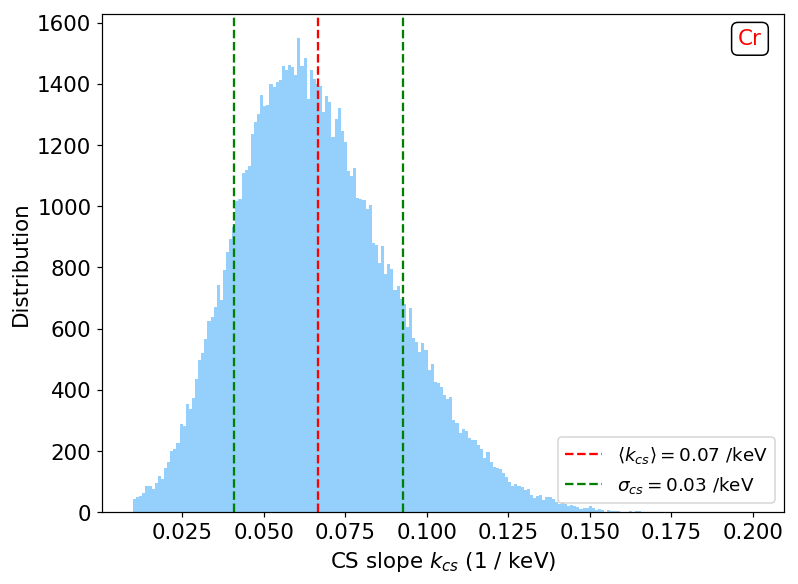

In [73]:
fig = en_cs_dist(k_data, 0)

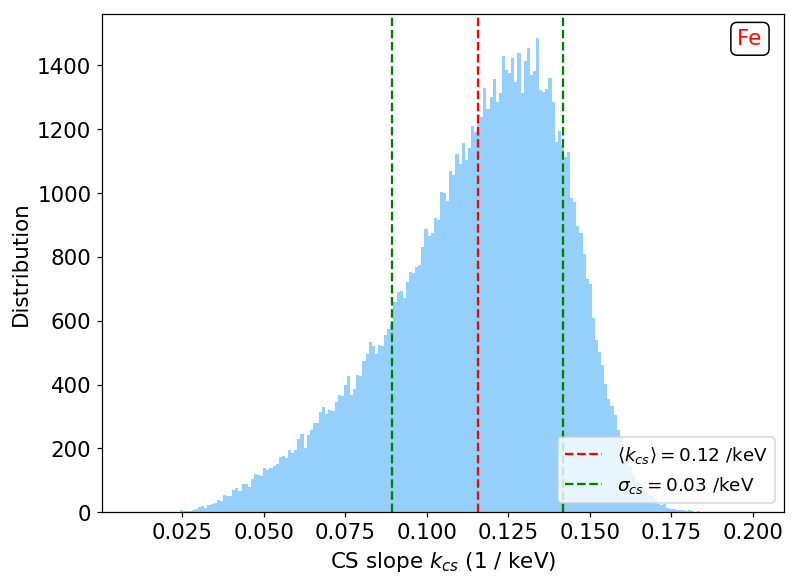

In [74]:
fig = en_cs_dist(k_data, 1)

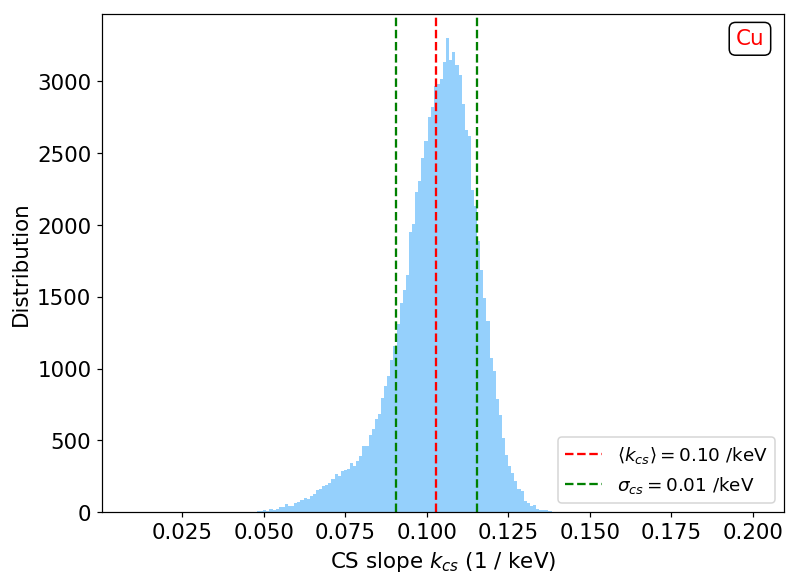

In [75]:
fig = en_cs_dist(k_data, 2)

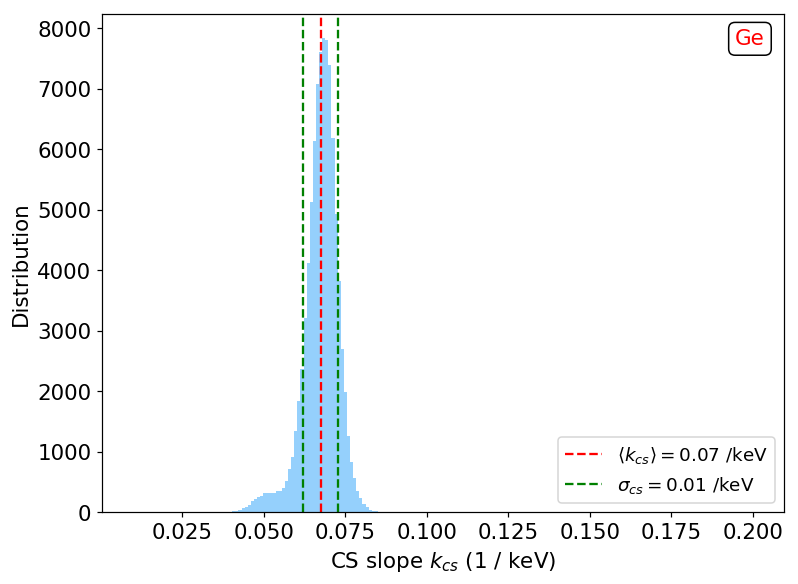

In [76]:
fig = en_cs_dist(k_data, 3)

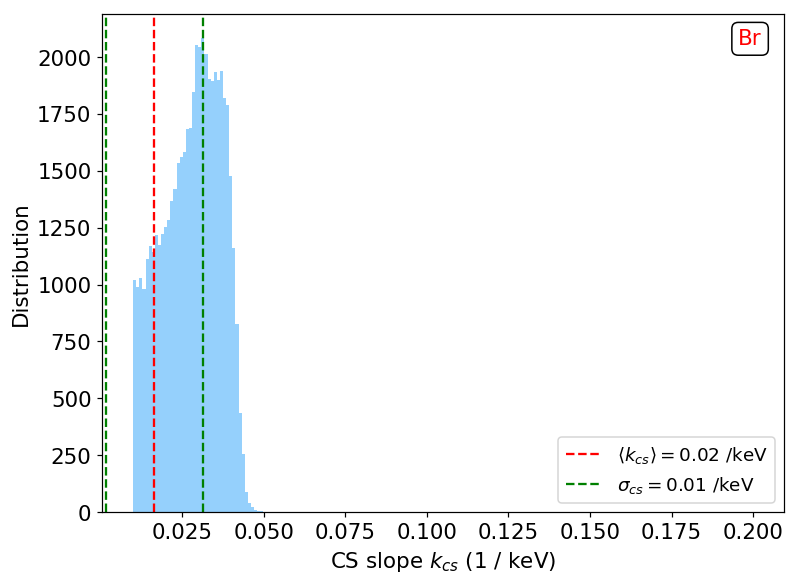

In [77]:
fig = en_cs_dist(k_data, 4)

In [86]:
def en_width_dist(k_data, index, xrange=[0.01, 0.2]):
    fig = plt.figure(1, figsize=(8,6), dpi=110)
    ax = fig.add_subplot(1, 1, 1)
    plt.tick_params(labelsize=14)

    # Sort the data and remove bad fits at 0
    Ew_set = k_data['width'][index, :, :].ravel()
    Ew_set = np.array([Ew_set[n] for n in range(len(Ew_set)) if n not in np.where(Ew_set == 0)[0]])

    # Do some basic stats
    mean = np.mean(Ew_set)
    stdev = np.std(Ew_set)

    hist, bins, patches = ax.hist(Ew_set, bins=200, color='xkcd:light blue')#, range=xrange)
    ax.axvline(x=mean, linestyle='dashed', color='red', label=r'$\langle E_w \rangle = {0:.2f}$ keV'.format(mean))
    ax.axvline(x=mean+stdev, linestyle='dashed', color='green', label=r'$\sigma_{{w}} = {0:.2f}$ keV'.format(stdev))
    ax.axvline(x=mean-stdev, linestyle='dashed', color='green')

    ax.legend(loc='lower right', fontsize=12)
    ax.set_xlabel(r'S-curve width $E_w$ (keV)', fontsize=14)
    ax.set_ylabel('Distribution', fontsize=14)

    ax.text(0.95, 0.95, k_data['elements'][index], horizontalalignment='center', verticalalignment='center',
            transform = ax.transAxes, fontsize=14, color='red',
            bbox=dict(facecolor='none', edgecolor='black', fc='w', boxstyle='round'))
    
    return fig

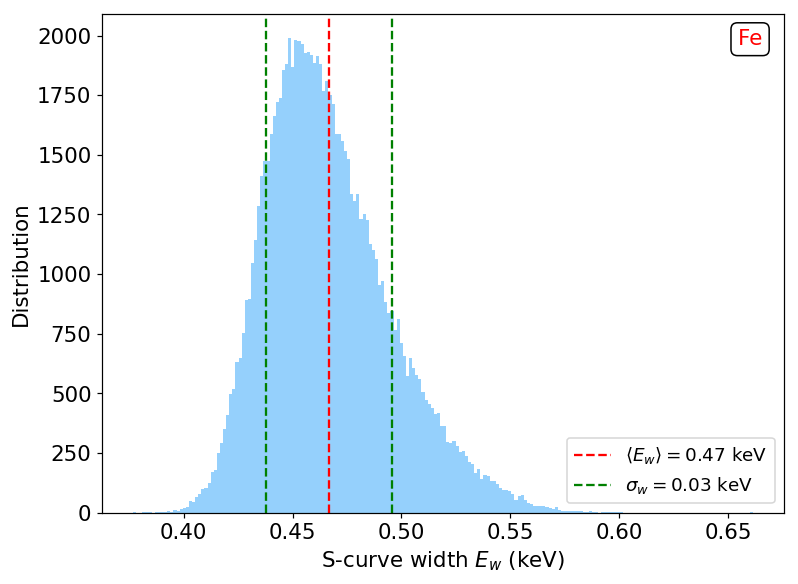

In [87]:
fig = en_width_dist(k_data, 1)

Plot the scaling of the averages

In [88]:
k_avg = np.zeros(len(k_data['elements']))
k_err = np.zeros(len(k_data['elements']))

for index in range(len(k_data['elements'])):
    k_set = k_data['slope'][index, :, :].ravel()
    k_set = np.array([k_set[n] for n in range(len(k_set)) if n not in np.where(k_set == 0)[0]])

    # Do some basic stats
    k_avg[index] = np.mean(k_set)
    k_err[index] = np.std(k_set)

Text(0,0.5,'CS slope $k_{cs}$ (1 / keV)')

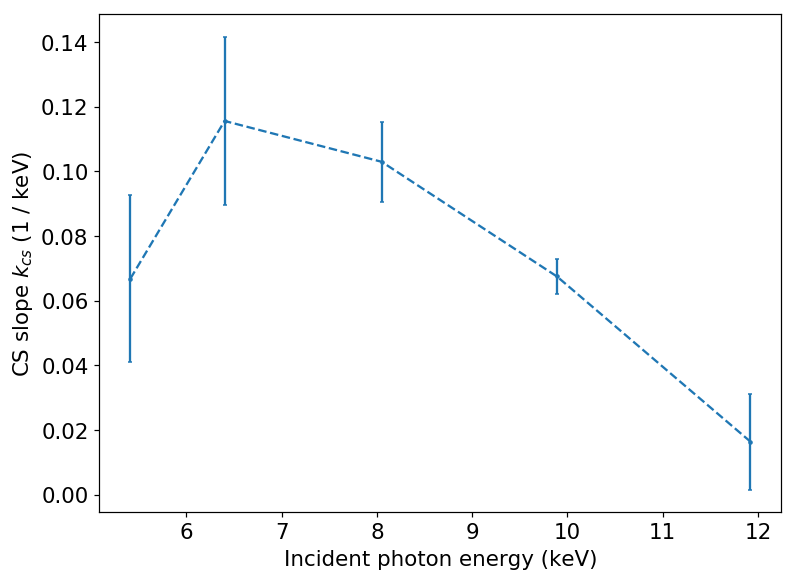

In [91]:
fig = plt.figure(1, figsize=(8,6), dpi=110)
ax = fig.add_subplot(1, 1, 1)
plt.tick_params(labelsize=14)

ax.errorbar(k_data['energy'], k_avg, yerr=k_err, capsize=1, ms=2, marker='o', linestyle='dashed', label='Data')
ax.set_xlabel('Incident photon energy (keV)', fontsize=14)
ax.set_ylabel(r'CS slope $k_{cs}$ (1 / keV)', fontsize=14)